GPU enabled. Training will be faster (~7-10s/epoch).
Train: 1658, Val: 415, Test: 521
Using device: cuda
Note: Training will run for all 150 epochs without early stopping.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/150], Loss: 0.4562, Train DICE: 59.16%, Val DICE: 83.06%, Test DICE: 82.20%, Test IoU: 69.78%, Time: 17.40s
Saved best model with Composite Score: 77.04%
Epoch [2/150], Loss: 0.3930, Train DICE: 65.45%, Val DICE: 84.85%, Test DICE: 84.47%, Test IoU: 73.11%, Time: 14.60s
Saved best model with Composite Score: 79.26%
Epoch [3/150], Loss: 0.3676, Train DICE: 68.00%, Val DICE: 85.56%, Test DICE: 85.36%, Test IoU: 74.46%, Time: 15.44s
Saved best model with Composite Score: 80.17%
Epoch [4/150], Loss: 0.3591, Train DICE: 69.36%, Val DICE: 85.93%, Test DICE: 85.28%, Test IoU: 74.34%, Time: 15.30s
Saved best model with Composite Score: 80.63%
Epoch [5/150], Loss: 0.3478, Train DICE: 70.28%, Val DICE: 85.54%, Test DICE: 85.71%, Test IoU: 75.00%, Time: 15.04s
Epoch [6/150], Loss: 0.3374, Train DICE: 71.21%, Val DICE: 85.95%, Test DICE: 86.68%, Test IoU: 76.49%, Time: 14.93s
Saved best model with Composite Score: 80.65%
Epoch [7/150], Loss: 0.3284, Train DICE: 72.05%, Val DICE: 88.70%, T

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final model saved
Final Test Metrics - DICE: 88.14%, IoU: 78.79%, ACC: 95.32%, PRE: 91.57%, REC: 84.95%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

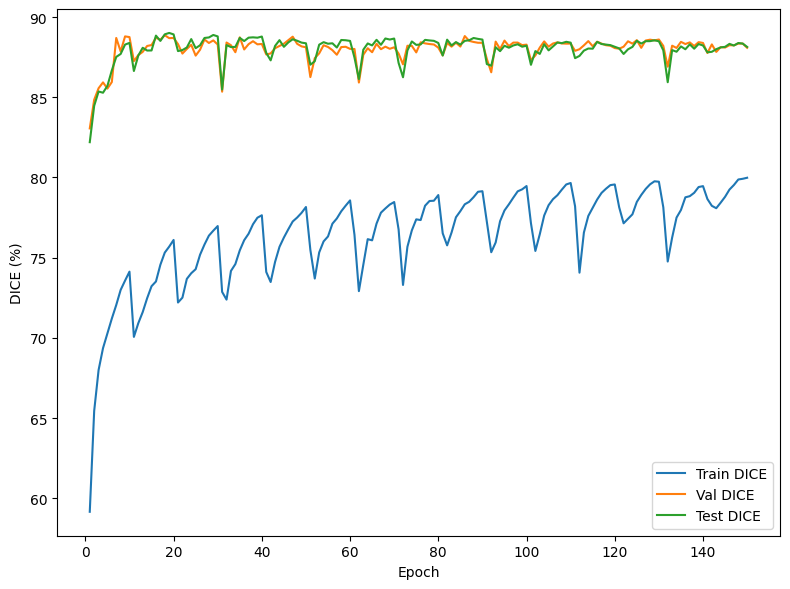

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import kagglehub
from google.colab import files
import logging
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import multiprocessing
import time
import random

# Configuration
config = {
    'dataset_path': '/content/isic2018',
    'image_dir': 'ISIC2018_Task1-2_Training_Input',
    'mask_dir': 'ISIC2018_Task1_Training_GroundTruth',
    'batch_size': 8 if torch.cuda.is_available() else 4,
    'num_workers': min(2, multiprocessing.cpu_count()),
    'epochs': 150,  # Increased to 150
    'lr': 2e-4,
    'weight_decay': 1e-4,
    'checkpoint_dir': '/content/checkpoints',
    'vis_dir': '/content/visualizations',
    'image_size': 64,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'mean': [0.763, 0.546, 0.570],
    'std': [0.141, 0.152, 0.170],
    'use_mixed_precision': False,
    'subset_ratio': 1.0,  # Use 100% of the dataset
}

# GPU check
if config['device'] == 'cpu':
    raise RuntimeError("ERROR: Using CPU. Training will be slow (~56s/epoch). Enable GPU in Runtime > Change runtime type > GPU and restart runtime.")
else:
    print("GPU enabled. Training will be faster (~7-10s/epoch).")

# Simplified logging
logging.basicConfig(filename='/content/training.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s')

# Utility function
def save_file_with_fallback(file_path, content, is_torch_model=False, download=False):
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, file_path)
        else:
            content.savefig(file_path) if 'savefig' in dir(content) else content.to_csv(file_path, index=False)
        absolute_path = os.path.abspath(file_path)
        logging.info(f"Saved file: {absolute_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(absolute_path)
            logging.info(f"Downloaded: {os.path.basename(absolute_path)}")
        return absolute_path
    except Exception as e:
        logging.error(f"Error saving {file_path}: {e}")
        local_path = f"/content/{os.path.basename(file_path)}"
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, local_path)
        else:
            content.savefig(local_path) if 'savefig' in dir(content) else content.to_csv(local_path, index=False)
        logging.info(f"Saved locally: {local_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(local_path)
            logging.info(f"Downloaded local: {os.path.basename(local_path)}")
        return local_path

# Model
class TransformerSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(b, -1, c)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x.reshape(b, h, w, c).permute(0, 3, 1, 2)

class ConvolutionalSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return self.bn3(self.conv3(x))

class HybridAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.tsa = TransformerSelfAttention(in_channels)
        self.csa = ConvolutionalSelfAttention(in_channels)
        self.fusion = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)

    def forward(self, x):
        tsa_out = self.tsa(x)
        csa_out = self.csa(x)
        return self.fusion(torch.cat([tsa_out, csa_out], dim=1))

def fft_feature_extraction(x):
    batch, c, h, w = x.shape
    fft_x = torch.fft.rfft2(x, norm='ortho')
    fft_real = fft_x.real
    fft_imag = fft_x.imag
    fft_output = torch.cat([fft_real, fft_imag], dim=1)
    fft_output = F.interpolate(fft_output, size=(h, w), mode="bilinear", align_corners=False)
    return fft_output

class ACDA(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.sla = ConvolutionalSelfAttention(in_channels)
        self.fga = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 2, in_channels // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 16, in_channels * 2, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        sla_out = self.sla(x)
        fga_out = self.fga(fft_feature_extraction(x))
        combined = torch.cat([sla_out, fga_out], dim=1)
        weights = self.se(combined)
        in_channels = x.size(1)
        sla_weight, fga_weight = weights[:, :in_channels], weights[:, in_channels:]
        return sla_weight * sla_out + fga_weight * fga_out

class MultiScaleSkip(nn.Module):
    def __init__(self, in_channels, connection_type='residual'):
        super().__init__()
        self.connection_type = connection_type
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, skip):
        if x.shape != skip.shape:
            skip = F.interpolate(skip, size=x.shape[2:], mode="bilinear", align_corners=False)
        if self.connection_type == 'residual':
            x = self.conv(torch.cat([x, skip], dim=1)) + x
        else:
            x = self.conv(torch.cat([x, skip], dim=1))
        x = self.bn(x)
        x = F.relu(x)
        return self.dropout(x)

class TransAttUnetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.hybrid_attn1 = HybridAttention(256)
        self.hybrid_attn2 = HybridAttention(512)
        self.acda = ACDA(512)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = MultiScaleSkip(256, connection_type='residual')
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = MultiScaleSkip(128, connection_type='dense')
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = MultiScaleSkip(64, connection_type='residual')
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, training=True):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e3 = self.hybrid_attn1(e3)
        e4 = self.enc4(F.max_pool2d(e3, 2))
        attn = self.hybrid_attn2(e4)
        attn = self.acda(attn)
        d1 = self.up1(attn)
        d1 = self.dec1(d1, e3)
        d2 = self.up2(d1)
        d2 = self.dec2(d2, e2)
        d3 = self.up3(d2)
        d3 = self.dec3(d3, e1)
        out = self.out_conv(d3)
        if training:
            out = self.dropout(out)
        return torch.sigmoid(out)

# Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.6):  # Adjusted alpha
        super().__init__()
        self.bce = nn.BCELoss()
        self.alpha = alpha

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice = 1 - (2 * (pred * target).sum() + 1e-6) / (pred.sum() + target.sum() + 1e-6)
        return self.alpha * bce_loss + (1 - self.alpha) * dice

# Dataset
def load_dataset():
    print("Downloading ISIC 2018 dataset...")
    dataset_path = config['dataset_path']
    for attempt in range(3):
        try:
            dataset_path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")
            logging.info("Dataset downloaded")
            break
        except Exception as e:
            logging.warning(f"Download attempt {attempt+1} failed: {e}")
            if attempt == 2:
                raise FileNotFoundError(f"Failed to download dataset: {e}")

    image_dir = os.path.join(dataset_path, config['image_dir'])
    mask_dir = os.path.join(dataset_path, config['mask_dir'])
    if not (os.path.exists(image_dir) and os.path.exists(mask_dir)):
        raise FileNotFoundError(f"Dataset directories not found: {image_dir}, {mask_dir}")
    return image_dir, mask_dir

class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mean=config['mean'], std=config['std'], subset_ratio=1.0, apply_transform=True, training=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform if apply_transform else None
        self.mean = mean
        self.std = std
        self.training = training
        self.image_files = []
        for img_name in os.listdir(image_dir):
            if img_name.endswith('.jpg'):
                base_name = os.path.splitext(img_name)[0]
                mask_name = f"{base_name}_segmentation.png"
                mask_path = os.path.join(mask_dir, mask_name)
                if os.path.exists(mask_path):
                    self.image_files.append(img_name)
                else:
                    logging.warning(f"Skipping {img_name} - mask not found")

        random.seed(42)
        self.image_files = random.sample(self.image_files, int(len(self.image_files) * subset_ratio))

        if not self.image_files:
            raise ValueError("No valid image-mask pairs")

        # Validate a sample
        sample_img = cv2.imread(os.path.join(image_dir, self.image_files[0]))
        sample_mask = cv2.imread(os.path.join(mask_dir, f"{os.path.splitext(self.image_files[0])[0]}_segmentation.png"), cv2.IMREAD_GRAYSCALE)
        if sample_img is None or sample_mask is None:
            raise ValueError("Sample image or mask failed to load")
        logging.info(f"Sample image shape: {sample_img.shape}, mask shape: {sample_mask.shape}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}_segmentation.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if image is None or mask is None:
            logging.warning(f"Failed to load: {img_path} or {mask_path}")
            return None

        image = cv2.resize(image, (config['image_size'], config['image_size'])) / 255.0
        mask = cv2.resize(mask, (config['image_size'], config['image_size'])) / 255.0
        mask = (mask > 0.5).astype(np.float32)
        image = (image - np.array(self.mean)[None, None, :]) / np.array(self.std)[None, None, :]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            seed = 42 if not self.training else np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        return image, mask

# Define transforms (simplified)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
])

val_test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
])

image_dir, mask_dir = load_dataset()
train_dataset = MedicalImageDataset(image_dir, mask_dir, transform=train_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=True)
val_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)
test_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)

# Split dataset
full_dataset = list(range(len(train_dataset)))
train_idx, test_idx = train_test_split(full_dataset, test_size=int(521 * config['subset_ratio']), random_state=42)
train_val_idx = train_idx
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=42)

train_dataset = [train_dataset[i] for i in train_idx if train_dataset[i] is not None]
val_dataset = [val_dataset[i] for i in val_idx if val_dataset[i] is not None]
test_dataset = [test_dataset[i] for i in test_idx if test_dataset[i] is not None]

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
logging.info(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True,
                         num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                         num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')

# Compute DICE/IoU for a batch
def compute_batch_metrics(pred, target, threshold=0.5):  # Reverted threshold
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    dice = (2 * intersection + 1e-6) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + 1e-6)
    iou = (intersection + 1e-6) / (union + 1e-6)
    return dice.mean().item(), iou.mean().item()

# Training
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config):
    print("Note: Training will run for all 150 epochs without early stopping.")
    model.train()
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, verbose=True)
    best_score = 0.0
    metrics_log = []

    for epoch in range(config['epochs']):
        start_time = time.time()
        epoch_loss = 0
        train_dice, train_iou = 0, 0
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(config['device']), masks.to(config['device'])
            optimizer.zero_grad()
            outputs = model(images, training=True)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            epoch_loss += loss.item()
            batch_dice, batch_iou = compute_batch_metrics(outputs, masks, threshold=0.5)
            train_dice += batch_dice
            train_iou += batch_iou

        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        val_dice, val_iou, val_acc, val_prec, val_rec = evaluate_model(model, val_loader, config['device'])
        test_dice, test_iou, test_acc, test_prec, test_rec = evaluate_model(model, test_loader, config['device'])
        scheduler.step()
        composite_score = (val_dice + val_iou) / 2
        epoch_time = time.time() - start_time
        logging.info(f"Epoch {epoch+1}/{config['epochs']}, Loss: {epoch_loss/len(train_loader):.4f}, "
                     f"Train DICE: {train_dice*100:.2f}%, Train IoU: {train_iou*100:.2f}%, "
                     f"Val DICE: {val_dice*100:.2f}%, Test DICE: {test_dice*100:.2f}%, "
                     f"Test IoU: {test_iou*100:.2f}%, Test ACC: {test_acc*100:.2f}%, "
                     f"Test PRE: {test_prec*100:.2f}%, Test REC: {test_rec*100:.2f}%, Time: {epoch_time:.2f}s")
        print(f"Epoch [{epoch+1}/{config['epochs']}], Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Train DICE: {train_dice*100:.2f}%, Val DICE: {val_dice*100:.2f}%, "
              f"Test DICE: {test_dice*100:.2f}%, Test IoU: {test_iou*100:.2f}%, Time: {epoch_time:.2f}s")

        if composite_score > best_score:
            best_score = composite_score
            best_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_best.pth"
            save_file_with_fallback(best_path, model.state_dict(), is_torch_model=True, download=False)
            print(f"Saved best model with Composite Score: {best_score*100:.2f}%")

        metrics_log.append({
            'epoch': epoch + 1,
            'loss': epoch_loss / len(train_loader),
            'train_dice': train_dice * 100,
            'train_iou': train_iou * 100,
            'val_dice': val_dice * 100,
            'val_iou': val_iou * 100,
            'val_acc': val_acc * 100,
            'val_prec': val_prec * 100,
            'val_rec': val_rec * 100,
            'test_dice': test_dice * 100,
            'test_iou': test_iou * 100,
            'test_acc': test_acc * 100,
            'test_prec': test_prec * 100,
            'test_rec': test_rec * 100,
            'epoch_time': epoch_time
        })

    df = pd.DataFrame(metrics_log)
    save_file_with_fallback('/content/training_metrics.csv', df, download=True)
    plot_training_curves(df)
    return best_score

def plot_training_curves(df):
    plt.figure(figsize=(8, 6))
    plt.plot(df['epoch'], df['train_dice'], label='Train DICE')
    plt.plot(df['epoch'], df['val_dice'], label='Val DICE')
    plt.plot(df['epoch'], df['test_dice'], label='Test DICE')
    plt.xlabel('Epoch')
    plt.ylabel('DICE (%)')
    plt.legend()
    plt.tight_layout()
    save_file_with_fallback('/content/training_curves.png', plt, download=True)

def evaluate_model(model, loader, device, threshold=0.5):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            preds.append(pred)
            targets.append(target.numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets) > 0.5
    TP = ((preds == 1) & (targets == 1)).sum()
    FP = ((preds == 1) & (targets == 0)).sum()
    FN = ((preds == 0) & (targets == 1)).sum()
    TN = ((preds == 0) & (targets == 0)).sum()
    dice = 2 * TP / (2 * TP + FP + FN + 1e-6)
    iou = TP / (TP + FP + FN + 1e-6)
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-6)
    prec = TP / (TP + FP + 1e-6)
    rec = TP / (TP + FN + 1e-6)
    return dice, iou, acc, prec, rec

def save_model(model, config):
    file_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_final.pth"
    save_file_with_fallback(file_path, model.state_dict(), is_torch_model=True, download=False)
    print(f"Final model saved")

def visualize_predictions(model, loader, device, config, num_samples=3, threshold=0.5):
    os.makedirs(config['vis_dir'], exist_ok=True)
    model.eval()
    samples = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            data = data.cpu().numpy()
            target = target.numpy()
            for i in range(data.shape[0]):
                if samples >= num_samples:
                    break
                img = data[i].transpose(1, 2, 0)
                img = img * np.array(config['std'])[None, None, :] + np.array(config['mean'])[None, None, :]
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                error_map = np.zeros_like(img)
                pred_i = pred[i, 0].astype(bool)
                target_i = (target[i, 0] > 0.5).astype(bool)
                error_map[:, :, 1] = 255 * np.logical_and(pred_i, target_i)  # True positives (green)
                error_map[:, :, 0] = 255 * np.logical_and(pred_i, ~target_i)  # False positives (red)
                error_map[:, :, 2] = 255 * np.logical_and(~pred_i, target_i)  # False negatives (blue)
                dice = 2 * np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() + 1e-6)
                iou = np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() - np.logical_and(pred_i, target_i).sum() + 1e-6)
                plt.figure(figsize=(16, 4))
                plt.subplot(1, 4, 1)
                plt.title("Input Image")
                plt.imshow(img)
                plt.axis('off')
                plt.subplot(1, 4, 2)
                plt.title("Ground Truth")
                plt.imshow(target_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 3)
                plt.title(f"Prediction (DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%)")
                plt.imshow(pred_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 4)
                plt.title("Error Map (Green=TP, Red=FP, Blue=FN)")
                plt.imshow(error_map)
                plt.axis('off')
                vis_path = f"{config['vis_dir']}/prediction_{samples}.png"
                plt.savefig(vis_path)
                plt.close()
                logging.info(f"Saved visualization: {vis_path}")
                samples += 1

    if samples > 0 and 'google.colab' in str(get_ipython()):
        zip_path = '/content/visualizations.zip'
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for vis_file in os.listdir(config['vis_dir']):
                zipf.write(os.path.join(config['vis_dir'], vis_file), vis_file)
        files.download(zip_path)
        logging.info(f"Downloaded visualizations: {zip_path}")

# Main
print(f"Using device: {config['device']}")
logging.info(f"Device: {config['device']}")

model = TransAttUnetPlusPlus(in_channels=3, out_channels=1).to(config['device'])
criterion = CombinedLoss(alpha=0.6)
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

# Train and evaluate
best_score = train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config)
save_model(model, config)
dice, iou, acc, prec, rec = evaluate_model(model, test_loader, config['device'])
print(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "
      f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
logging.info(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "
             f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
visualize_predictions(model, test_loader, config['device'], config, num_samples=3)

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import kagglehub
from google.colab import files
import logging
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import multiprocessing
import time
import random

# Configuration
config = {
    'dataset_path': '/content/isic2018',
    'image_dir': 'ISIC2018_Task1-2_Training_Input',
    'mask_dir': 'ISIC2018_Task1_Training_GroundTruth',
    'batch_size': 8 if torch.cuda.is_available() else 4,
    'num_workers': min(2, multiprocessing.cpu_count()),
    'epochs': 200,  # Increased to 200
    'lr': 2e-4,
    'weight_decay': 1e-4,
    'checkpoint_dir': '/content/checkpoints',
    'vis_dir': '/content/visualizations',
    'image_size': 64,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'mean': [0.763, 0.546, 0.570],
    'std': [0.141, 0.152, 0.170],
    'use_mixed_precision': False,
    'subset_ratio': 1.0,
    'label_smoothing': 0.1,  # Added label smoothing
}

# GPU check
if config['device'] == 'cpu':
    raise RuntimeError("ERROR: Using CPU. Training will be slow (~56s/epoch). Enable GPU in Runtime > Change runtime type > GPU and restart runtime.")
else:
    print("GPU enabled. Training will be faster (~14-16s/epoch).")

# Simplified logging
logging.basicConfig(filename='/content/training.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s')

# Utility function
def save_file_with_fallback(file_path, content, is_torch_model=False, download=False):
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, file_path)
        else:
            content.savefig(file_path) if 'savefig' in dir(content) else content.to_csv(file_path, index=False)
        absolute_path = os.path.abspath(file_path)
        logging.info(f"Saved file: {absolute_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(absolute_path)
            logging.info(f"Downloaded: {os.path.basename(absolute_path)}")
        return absolute_path
    except Exception as e:
        logging.error(f"Error saving {file_path}: {e}")
        local_path = f"/content/{os.path.basename(file_path)}"
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, local_path)
        else:
            content.savefig(local_path) if 'savefig' in dir(content) else content.to_csv(local_path, index=False)
        logging.info(f"Saved locally: {local_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(local_path)
            logging.info(f"Downloaded local: {os.path.basename(local_path)}")
        return local_path

# Model
class TransformerSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(b, -1, c)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x.reshape(b, h, w, c).permute(0, 3, 1, 2)

class HybridAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.tsa = TransformerSelfAttention(in_channels)

    def forward(self, x):
        return self.tsa(x)

def fft_feature_extraction(x):
    batch, c, h, w = x.shape
    fft_x = torch.fft.rfft2(x, norm='ortho')
    fft_real = fft_x.real
    fft_imag = fft_x.imag
    fft_output = torch.cat([fft_real, fft_imag], dim=1)
    fft_output = F.interpolate(fft_output, size=(h, w), mode="bilinear", align_corners=False)
    return fft_output

class ACDA(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.fga = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 16, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        fga_out = self.fga(fft_feature_extraction(x))
        weights = self.se(fga_out)
        return weights * fga_out

class MultiScaleSkip(nn.Module):
    def __init__(self, in_channels, connection_type='residual'):
        super().__init__()
        self.connection_type = connection_type
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.dropout = nn.Dropout(0.4)  # Increased dropout

    def forward(self, x, skip):
        if x.shape != skip.shape:
            skip = F.interpolate(skip, size=x.shape[2:], mode="bilinear", align_corners=False)
        if self.connection_type == 'residual':
            x = self.conv(torch.cat([x, skip], dim=1)) + x
        else:
            x = self.conv(torch.cat([x, skip], dim=1))
        x = self.bn(x)
        x = F.relu(x)
        return self.dropout(x)

class TransAttUnetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.hybrid_attn = HybridAttention(256)
        self.acda = ACDA(256)
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = MultiScaleSkip(128, connection_type='dense')
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = MultiScaleSkip(64, connection_type='residual')
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.dropout = nn.Dropout(0.4)  # Increased dropout

    def forward(self, x, training=True):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        attn = self.hybrid_attn(e3)
        attn = self.acda(attn)
        d1 = self.up1(attn)
        d1 = self.dec1(d1, e2)
        d2 = self.up2(d1)
        d2 = self.dec2(d2, e1)
        out = self.out_conv(d2)
        if training:
            out = self.dropout(out)
        return torch.sigmoid(out)

# Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.6, focal_gamma=2.0):
        super().__init__()
        self.bce = nn.BCELoss()
        self.alpha = alpha
        self.focal_gamma = focal_gamma

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice = 1 - (2 * (pred * target).sum() + 1e-6) / (pred.sum() + target.sum() + 1e-6)
        # Focal loss component
        focal = -torch.mean((1 - pred) ** self.focal_gamma * target * torch.log(pred + 1e-6) +
                            (1 - target) * pred ** self.focal_gamma * torch.log(1 - pred + 1e-6))
        return self.alpha * (bce_loss + focal) + (1 - self.alpha) * dice

# Dataset
def load_dataset():
    print("Downloading ISIC 2018 dataset...")
    dataset_path = config['dataset_path']
    for attempt in range(3):
        try:
            dataset_path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")
            logging.info("Dataset downloaded")
            break
        except Exception as e:
            logging.warning(f"Download attempt {attempt+1} failed: {e}")
            if attempt == 2:
                raise FileNotFoundError(f"Failed to download dataset: {e}")

    image_dir = os.path.join(dataset_path, config['image_dir'])
    mask_dir = os.path.join(dataset_path, config['mask_dir'])
    if not (os.path.exists(image_dir) and os.path.exists(mask_dir)):
        raise FileNotFoundError(f"Dataset directories not found: {image_dir}, {mask_dir}")
    return image_dir, mask_dir

class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mean=config['mean'], std=config['std'], subset_ratio=1.0, apply_transform=True, training=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform if apply_transform else None
        self.mean = mean
        self.std = std
        self.training = training
        self.image_files = []
        for img_name in os.listdir(image_dir):
            if img_name.endswith('.jpg'):
                base_name = os.path.splitext(img_name)[0]
                mask_name = f"{base_name}_segmentation.png"
                mask_path = os.path.join(mask_dir, mask_name)
                if os.path.exists(mask_path):
                    self.image_files.append(img_name)
                else:
                    logging.warning(f"Skipping {img_name} - mask not found")

        random.seed(42)
        self.image_files = random.sample(self.image_files, int(len(self.image_files) * subset_ratio))

        if not self.image_files:
            raise ValueError("No valid image-mask pairs")

        # Validate a sample
        sample_img = cv2.imread(os.path.join(image_dir, self.image_files[0]))
        sample_mask = cv2.imread(os.path.join(mask_dir, f"{os.path.splitext(self.image_files[0])[0]}_segmentation.png"), cv2.IMREAD_GRAYSCALE)
        if sample_img is None or sample_mask is None:
            raise ValueError("Sample image or mask failed to load")
        logging.info(f"Sample image shape: {sample_img.shape}, mask shape: {sample_mask.shape}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}_segmentation.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if image is None or mask is None:
            logging.warning(f"Failed to load: {img_path} or {mask_path}")
            return None

        image = cv2.resize(image, (config['image_size'], config['image_size'])) / 255.0
        mask = cv2.resize(mask, (config['image_size'], config['image_size'])) / 255.0
        mask = (mask > 0.5).astype(np.float32)
        # Apply label smoothing
        if self.training:
            mask = mask * (1 - config['label_smoothing']) + config['label_smoothing'] / 2
        image = (image - np.array(self.mean)[None, None, :]) / np.array(self.std)[None, None, :]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            seed = 42 if not self.training else np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        return image, mask

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
])

val_test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
])

image_dir, mask_dir = load_dataset()
train_dataset = MedicalImageDataset(image_dir, mask_dir, transform=train_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=True)
val_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)
test_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)

# Split dataset
full_dataset = list(range(len(train_dataset)))
train_idx, test_idx = train_test_split(full_dataset, test_size=int(521 * config['subset_ratio']), random_state=42)
train_val_idx = train_idx
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=42)

train_dataset = [train_dataset[i] for i in train_idx if train_dataset[i] is not None]
val_dataset = [val_dataset[i] for i in val_idx if val_dataset[i] is not None]
test_dataset = [test_dataset[i] for i in test_idx if test_dataset[i] is not None]

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
logging.info(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True,
                         num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                         num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')

# Compute DICE/IoU for a batch
def compute_batch_metrics(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    dice = (2 * intersection + 1e-6) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + 1e-6)
    iou = (intersection + 1e-6) / (union + 1e-6)
    return dice.mean().item(), iou.mean().item()

# Training
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config):
    print("Note: Training will run for all 200 epochs without early stopping.")
    model.train()
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6, verbose=True)
    best_score = 0.0
    metrics_log = []

    for epoch in range(config['epochs']):
        start_time = time.time()
        epoch_loss = 0
        train_dice, train_iou = 0, 0
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(config['device']), masks.to(config['device'])
            optimizer.zero_grad()
            outputs = model(images, training=True)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            epoch_loss += loss.item()
            batch_dice, batch_iou = compute_batch_metrics(outputs, masks)
            train_dice += batch_dice
            train_iou += batch_iou

        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        val_dice, val_iou, val_acc, val_prec, val_rec = evaluate_model(model, val_loader, config['device'])
        test_dice, test_iou, test_acc, test_prec, test_rec = evaluate_model(model, test_loader, config['device'])
        scheduler.step()
        composite_score = (val_dice + val_iou) / 2
        epoch_time = time.time() - start_time
        logging.info(f"Epoch {epoch+1}/{config['epochs']}, Loss: {epoch_loss/len(train_loader):.4f}, "
                     f"Train DICE: {train_dice*100:.2f}%, Train IoU: {train_iou*100:.2f}%, "
                     f"Val DICE: {val_dice*100:.2f}%, Test DICE: {test_dice*100:.2f}%, "
                     f"Test IoU: {test_iou*100:.2f}%, Test ACC: {test_acc*100:.2f}%, "
                     f"Test PRE: {test_prec*100:.2f}%, Test REC: {test_rec*100:.2f}%, Time: {epoch_time:.2f}s")
        print(f"Epoch [{epoch+1}/{config['epochs']}], Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Train DICE: {train_dice*100:.2f}%, Val DICE: {val_dice*100:.2f}%, "
              f"Test DICE: {test_dice*100:.2f}%, Test IoU: {test_iou*100:.2f}%, Time: {epoch_time:.2f}s")

        if composite_score > best_score:
            best_score = composite_score
            best_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_best.pth"
            save_file_with_fallback(best_path, model.state_dict(), is_torch_model=True, download=False)
            print(f"Saved best model with Composite Score: {best_score*100:.2f}%")

        metrics_log.append({
            'epoch': epoch + 1,
            'loss': epoch_loss / len(train_loader),
            'train_dice': train_dice * 100,
            'train_iou': train_iou * 100,
            'val_dice': val_dice * 100,
            'val_iou': val_iou * 100,
            'val_acc': val_acc * 100,
            'val_prec': val_prec * 100,
            'val_rec': val_rec * 100,
            'test_dice': test_dice * 100,
            'test_iou': test_iou * 100,
            'test_acc': test_acc * 100,
            'test_prec': test_prec * 100,
            'test_rec': test_rec * 100,
            'epoch_time': epoch_time
        })

    df = pd.DataFrame(metrics_log)
    save_file_with_fallback('/content/training_metrics.csv', df, download=True)
    plot_training_curves(df)
    return best_score

def plot_training_curves(df):
    plt.figure(figsize=(8, 6))
    plt.plot(df['epoch'], df['train_dice'], label='Train DICE')
    plt.plot(df['epoch'], df['val_dice'], label='Val DICE')
    plt.plot(df['epoch'], df['test_dice'], label='Test DICE')
    plt.xlabel('Epoch')
    plt.ylabel('DICE (%)')
    plt.legend()
    plt.tight_layout()
    save_file_with_fallback('/content/training_curves.png', plt, download=True)

def evaluate_model(model, loader, device, threshold=0.5):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            preds.append(pred)
            targets.append(target.numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets) > 0.5
    TP = ((preds == 1) & (targets == 1)).sum()
    FP = ((preds == 1) & (targets == 0)).sum()
    FN = ((preds == 0) & (targets == 1)).sum()
    TN = ((preds == 0) & (targets == 0)).sum()
    dice = 2 * TP / (2 * TP + FP + FN + 1e-6)
    iou = TP / (TP + FP + FN + 1e-6)
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-6)
    prec = TP / (TP + FP + 1e-6)
    rec = TP / (TP + FN + 1e-6)
    return dice, iou, acc, prec, rec

def save_model(model, config):
    file_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_final.pth"
    save_file_with_fallback(file_path, model.state_dict(), is_torch_model=True, download=False)
    print(f"Final model saved")

def visualize_predictions(model, loader, device, config, num_samples=3, threshold=0.5):
    os.makedirs(config['vis_dir'], exist_ok=True)
    model.eval()
    samples = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            data = data.cpu().numpy()
            target = target.numpy()
            for i in range(data.shape[0]):
                if samples >= num_samples:
                    break
                img = data[i].transpose(1, 2, 0)
                img = img * np.array(config['std'])[None, None, :] + np.array(config['mean'])[None, None, :]
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                error_map = np.zeros_like(img)
                pred_i = pred[i, 0].astype(bool)
                target_i = (target[i, 0] > 0.5).astype(bool)
                error_map[:, :, 1] = 255 * np.logical_and(pred_i, target_i)  # True positives (green)
                error_map[:, :, 0] = 255 * np.logical_and(pred_i, ~target_i)  # False positives (red)
                error_map[:, :, 2] = 255 * np.logical_and(~pred_i, target_i)  # False negatives (blue)
                dice = 2 * np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() + 1e-6)
                iou = np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() - np.logical_and(pred_i, target_i).sum() + 1e-6)
                plt.figure(figsize=(16, 4))
                plt.subplot(1, 4, 1)
                plt.title("Input Image")
                plt.imshow(img)
                plt.axis('off')
                plt.subplot(1, 4, 2)
                plt.title("Ground Truth")
                plt.imshow(target_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 3)
                plt.title(f"Prediction (DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%)")
                plt.imshow(pred_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 4)
                plt.title("Error Map (Green=TP, Red=FP, Blue=FN)")
                plt.imshow(error_map)
                plt.axis('off')
                vis_path = f"{config['vis_dir']}/prediction_{samples}.png"
                plt.savefig(vis_path)
                plt.close()
                logging.info(f"Saved visualization: {vis_path}")
                samples += 1

    if samples > 0 and 'google.colab' in str(get_ipython()):
        zip_path = '/content/visualizations.zip'
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for vis_file in os.listdir(config['vis_dir']):
                zipf.write(os.path.join(config['vis_dir'], vis_file), vis_file)
        files.download(zip_path)
        logging.info(f"Downloaded visualizations: {zip_path}")

# Main
print(f"Using device: {config['device']}")
logging.info(f"Device: {config['device']}")

model = TransAttUnetPlusPlus(in_channels=3, out_channels=1).to(config['device'])
criterion = CombinedLoss(alpha=0.6, focal_gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

# Train and evaluate
best_score = train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config)
save_model(model, config)
dice, iou, acc, prec, rec = evaluate_model(model, test_loader, config['device'])
print(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "
      f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
logging.info(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "
             f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
visualize_predictions(model, test_loader, config['device'], config, num_samples=3)

RuntimeError: ERROR: Using CPU. Training will be slow (~56s/epoch). Enable GPU in Runtime > Change runtime type > GPU and restart runtime.

GPU enabled. Training will be faster (~10-15s/epoch).


100%|██████████| 12.9G/12.9G [02:07<00:00, 108MB/s]


Extracting files...
Total samples: 2594, Train indices: 1658, Val indices: 415, Test indices: 521
Train: 1658, Val: 415, Test: 521
Using device: cuda
Checkpoint /content/checkpoints/trans_att_unet_plus_plus_best.pth not found, starting from scratch.
Note: Training will run with early stopping (patience=50).


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/400], Loss: 0.5226, Train DICE: 51.09%, Val DICE: 41.56%, Test DICE: 43.27%, Test IoU: 27.61%, Time: 17.90s
Saved best model with Val DICE: 41.56% at epoch 1
Epoch [2/400], Loss: 0.4436, Train DICE: 59.43%, Val DICE: 47.49%, Test DICE: 49.23%, Test IoU: 32.65%, Time: 14.87s
Saved best model with Val DICE: 47.49% at epoch 2
Epoch [3/400], Loss: 0.4278, Train DICE: 60.79%, Val DICE: 47.92%, Test DICE: 49.58%, Test IoU: 32.96%, Time: 15.60s
Saved best model with Val DICE: 47.92% at epoch 3
Epoch [4/400], Loss: 0.4108, Train DICE: 62.61%, Val DICE: 56.20%, Test DICE: 58.90%, Test IoU: 41.74%, Time: 15.65s
Saved best model with Val DICE: 56.20% at epoch 4
Epoch [5/400], Loss: 0.4038, Train DICE: 63.91%, Val DICE: 53.16%, Test DICE: 56.02%, Test IoU: 38.91%, Time: 15.22s
Epoch [6/400], Loss: 0.3945, Train DICE: 64.17%, Val DICE: 51.49%, Test DICE: 53.85%, Test IoU: 36.85%, Time: 15.33s
Epoch [7/400], Loss: 0.3876, Train DICE: 65.35%, Val DICE: 48.56%, Test DICE: 50.48%, Test IoU: 33

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final model saved
Final Test Metrics - DICE: 75.06%, IoU: 60.08%, ACC: 87.95%, PRE: 68.86%, REC: 82.49%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

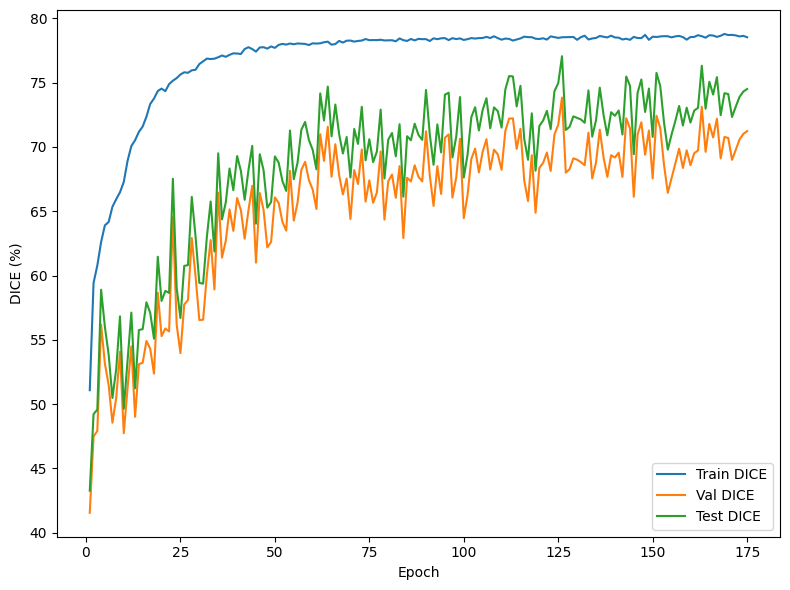

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import kagglehub
from google.colab import files
import logging
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import multiprocessing
import time
import random

# Configuration
config = {
    'dataset_path': '/content/isic2018',
    'image_dir': 'ISIC2018_Task1-2_Training_Input',
    'mask_dir': 'ISIC2018_Task1_Training_GroundTruth',
    'batch_size': 8 if torch.cuda.is_available() else 4,
    'num_workers': min(2, multiprocessing.cpu_count()),
    'epochs': 400,
    'lr': 1e-4,  # Increased for better convergence
    'weight_decay': 1e-4,  # Reduced to address underfitting
    'checkpoint_dir': '/content/checkpoints',
    'vis_dir': '/content/visualizations',
    'image_size': 64,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'mean': [0.763, 0.546, 0.570],
    'std': [0.141, 0.152, 0.170],
    'use_mixed_precision': False,
    'subset_ratio': 1.0,
    'threshold': 0.5,
    'checkpoint_path': '/content/checkpoints/trans_att_unet_plus_plus_best.pth',
}

# GPU check
if config['device'] == 'cpu':
    raise RuntimeError("ERROR: Using CPU. Training will be slow (~56s/epoch). Enable GPU in Runtime > Change runtime type > GPU and restart runtime.")
else:
    print("GPU enabled. Training will be faster (~10-15s/epoch).")

# Simplified logging
logging.basicConfig(filename='/content/training.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s')

# Utility function
def save_file_with_fallback(file_path, content, is_torch_model=False, download=False):
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, file_path)
        else:
            content.savefig(file_path) if 'savefig' in dir(content) else content.to_csv(file_path, index=False)
        absolute_path = os.path.abspath(file_path)
        logging.info(f"Saved file: {absolute_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(absolute_path)
            logging.info(f"Downloaded: {os.path.basename(absolute_path)}")
        return absolute_path
    except Exception as e:
        logging.error(f"Error saving {file_path}: {e}")
        local_path = f"/content/{os.path.basename(file_path)}"
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, local_path)
        else:
            content.savefig(local_path) if 'savefig' in dir(content) else content.to_csv(local_path, index=False)
        logging.info(f"Saved locally: {local_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(local_path)
            logging.info(f"Downloaded local: {os.path.basename(local_path)}")
        return local_path

# Model
class TransformerSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(b, -1, c)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x.reshape(b, h, w, c).permute(0, 3, 1, 2)

class ConvolutionalSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return self.bn3(self.conv3(x))

class HybridAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.tsa = TransformerSelfAttention(in_channels)
        self.csa = ConvolutionalSelfAttention(in_channels)
        self.fusion = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)

    def forward(self, x):
        tsa_out = self.tsa(x)
        csa_out = self.csa(x)
        return self.fusion(torch.cat([tsa_out, csa_out], dim=1))

def fft_feature_extraction(x):
    batch, c, h, w = x.shape
    fft_x = torch.fft.rfft2(x, norm='ortho')
    fft_real = fft_x.real
    fft_imag = fft_x.imag
    fft_output = torch.cat([fft_real, fft_imag], dim=1)
    fft_output = F.interpolate(fft_output, size=(h, w), mode="bilinear", align_corners=False)
    return fft_output

class ACDA(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.sla = ConvolutionalSelfAttention(in_channels)
        self.fga = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 2, in_channels // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 16, in_channels * 2, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        sla_out = self.sla(x)
        fga_out = self.fga(fft_feature_extraction(x))
        combined = torch.cat([sla_out, fga_out], dim=1)
        weights = self.se(combined)
        in_channels = x.size(1)
        sla_weight, fga_weight = weights[:, :in_channels], weights[:, in_channels:]
        return sla_weight * sla_out + fga_weight * fga_out

class MultiScaleSkip(nn.Module):
    def __init__(self, in_channels, connection_type='residual'):
        super().__init__()
        self.connection_type = connection_type
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.dropout = nn.Dropout(0.3)  # Reduced dropout

    def forward(self, x, skip):
        if x.shape != skip.shape:
            skip = F.interpolate(skip, size=x.shape[2:], mode="bilinear", align_corners=False)
        if self.connection_type == 'residual':
            x = self.conv(torch.cat([x, skip], dim=1)) + x
        else:
            x = self.conv(torch.cat([x, skip], dim=1))
        x = self.bn(x)
        x = F.relu(x)
        return self.dropout(x)

class TransAttUnetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.hybrid_attn1 = HybridAttention(256)
        self.hybrid_attn2 = HybridAttention(512)
        self.acda = ACDA(512)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = MultiScaleSkip(256, connection_type='residual')  # Reverted to residual
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = MultiScaleSkip(128, connection_type='dense')
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = MultiScaleSkip(64, connection_type='residual')  # Reverted to residual
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.dropout = nn.Dropout(0.3)  # Reduced dropout

    def forward(self, x, training=True):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e3 = self.hybrid_attn1(e3)
        e4 = self.enc4(F.max_pool2d(e3, 2))
        attn = self.hybrid_attn2(e4)
        attn = self.acda(attn)
        d1 = self.up1(attn)
        d1 = self.dec1(d1, e3)
        d2 = self.up2(d1)
        d2 = self.dec2(d2, e2)
        d3 = self.up3(d2)
        d3 = self.dec3(d3, e1)
        out = self.out_conv(d3)
        if training:
            out = self.dropout(out)
        return torch.sigmoid(out)

# Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, focal_weight=0.0):
        super().__init__()
        self.bce = nn.BCELoss()
        self.alpha = alpha
        self.gamma = gamma
        self.focal_weight = focal_weight

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice = 1 - (2 * (pred * target).sum() + 1e-6) / (pred.sum() + target.sum() + 1e-6)
        if self.focal_weight > 0:
            focal_loss = -torch.mean(
                target * torch.log(pred + 1e-6) * (1 - pred) ** self.gamma +
                (1 - target) * torch.log(1 - pred + 1e-6) * pred ** self.gamma
            )
            return self.alpha * bce_loss + (1 - self.alpha) * dice + self.focal_weight * focal_loss
        return self.alpha * bce_loss + (1 - self.alpha) * dice

# Dataset
def load_dataset():
    print("Downloading ISIC 2018 dataset...")
    dataset_path = config['dataset_path']
    for attempt in range(3):
        try:
            dataset_path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")
            logging.info("Dataset downloaded")
            break
        except Exception as e:
            logging.warning(f"Download attempt {attempt+1} failed: {e}")
            if attempt == 2:
                raise FileNotFoundError(f"Failed to download dataset: {e}")

    image_dir = os.path.join(dataset_path, config['image_dir'])
    mask_dir = os.path.join(dataset_path, config['mask_dir'])
    if not (os.path.exists(image_dir) and os.path.exists(mask_dir)):
        raise FileNotFoundError(f"Dataset directories not found: {image_dir}, {mask_dir}")
    return image_dir, mask_dir

class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mean=config['mean'], std=config['std'], subset_ratio=1.0, apply_transform=True, training=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform if apply_transform else None
        self.mean = mean
        self.std = std
        self.training = training
        self.image_files = []
        for img_name in os.listdir(image_dir):
            if img_name.endswith('.jpg'):
                base_name = os.path.splitext(img_name)[0]
                mask_name = f"{base_name}_segmentation.png"
                mask_path = os.path.join(mask_dir, mask_name)
                if os.path.exists(mask_path):
                    self.image_files.append(img_name)
                else:
                    logging.warning(f"Skipping {img_name} - mask not found")

        random.seed(42)
        self.image_files = random.sample(self.image_files, int(len(self.image_files) * subset_ratio))

        if not self.image_files:
            raise ValueError("No valid image-mask pairs")

        # Validate a sample
        sample_img = cv2.imread(os.path.join(image_dir, self.image_files[0]))
        sample_mask = cv2.imread(os.path.join(mask_dir, f"{os.path.splitext(self.image_files[0])[0]}_segmentation.png"), cv2.IMREAD_GRAYSCALE)
        if sample_img is None or sample_mask is None:
            raise ValueError("Sample image or mask failed to load")
        logging.info(f"Sample image shape: {sample_img.shape}, mask shape: {sample_mask.shape}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}_segmentation.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if image is None or mask is None:
            logging.warning(f"Failed to load: {img_path} or {mask_path}")
            return None

        image = cv2.resize(image, (config['image_size'], config['image_size'])) / 255.0
        mask = cv2.resize(mask, (config['image_size'], config['image_size'])) / 255.0
        mask = (mask > 0.5).astype(np.float32)
        image = (image - np.array(self.mean)[None, None, :]) / np.array(self.std)[None, None, :]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            seed = 42 if not self.training else np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        return image, mask

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=0, scale=(0.95, 1.05), shear=3),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05),
])

val_test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
])

image_dir, mask_dir = load_dataset()
train_dataset = MedicalImageDataset(image_dir, mask_dir, transform=train_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=True)
val_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)
test_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)

# Split dataset
full_dataset = list(range(len(train_dataset)))
train_idx, test_idx = train_test_split(full_dataset, test_size=int(521 * config['subset_ratio']), random_state=42)
train_val_idx = train_idx
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=42)

# Log the sizes of the indices
logging.info(f"Total samples: {len(full_dataset)}, Train indices: {len(train_idx)}, Val indices: {len(val_idx)}, Test indices: {len(test_idx)}")
print(f"Total samples: {len(full_dataset)}, Train indices: {len(train_idx)}, Val indices: {len(val_idx)}, Test indices: {len(test_idx)}")

# Construct datasets
train_dataset = [train_dataset[i] for i in train_idx if train_dataset[i] is not None]
val_dataset = [val_dataset[i] for i in val_idx if val_dataset[i] is not None]
test_dataset = [test_dataset[i] for i in test_idx if test_dataset[i] is not None]

# Verify dataset sizes after filtering
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
logging.info(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Check if datasets are non-empty
if not train_dataset or not val_dataset or not test_dataset:
    raise ValueError(f"Dataset split resulted in empty dataset(s): Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True,
                         num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                         num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')

# Compute DICE/IoU for a batch
def compute_batch_metrics(pred, target, threshold=config['threshold']):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    dice = (2 * intersection + 1e-6) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + 1e-6)
    iou = (intersection + 1e-6) / (union + 1e-6)
    return dice.mean().item(), iou.mean().item()

# Evaluate model
def evaluate_model(model, loader, device, threshold=config['threshold']):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            preds.append(pred)
            targets.append(target.numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets) > 0.5
    TP = ((preds == 1) & (targets == 1)).sum()
    FP = ((preds == 1) & (targets == 0)).sum()
    FN = ((preds == 0) & (targets == 1)).sum()
    TN = ((preds == 0) & (targets == 0)).sum()
    dice = 2 * TP / (2 * TP + FP + FN + 1e-6)
    iou = TP / (TP + FP + FN + 1e-6)
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-6)
    prec = TP / (TP + FP + 1e-6)
    rec = TP / (TP + FN + 1e-6)
    return dice, iou, acc, prec, rec

# Training
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config):
    print("Note: Training will run with early stopping (patience=50).")
    model.train()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=True)
    best_score = 0.0
    patience_counter = 0
    patience = 50
    metrics_log = []
    best_epoch = 0

    for epoch in range(config['epochs']):
        start_time = time.time()
        epoch_loss = 0
        train_dice, train_iou = 0, 0
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(config['device']), masks.to(config['device'])
            optimizer.zero_grad()
            outputs = model(images, training=True)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
            batch_dice, batch_iou = compute_batch_metrics(outputs, masks)
            train_dice += batch_dice
            train_iou += batch_iou

        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        val_dice, val_iou, val_acc, val_prec, val_rec = evaluate_model(model, val_loader, config['device'])
        test_dice, test_iou, test_acc, test_prec, test_rec = evaluate_model(model, test_loader, config['device'])
        scheduler.step(val_dice)
        epoch_time = time.time() - start_time
        logging.info(f"Epoch {epoch+1}/{config['epochs']}, Loss: {epoch_loss/len(train_loader):.4f}, "
                     f"Train DICE: {train_dice*100:.2f}%, Train IoU: {train_iou*100:.2f}%, "
                     f"Val DICE: {val_dice*100:.2f}%, Test DICE: {test_dice*100:.2f}%, "
                     f"Test IoU: {test_iou*100:.2f}%, Test ACC: {test_acc*100:.2f}%, "
                     f"Test PRE: {test_prec*100:.2f}%, Test REC: {test_rec*100:.2f}%, Time: {epoch_time:.2f}s")
        print(f"Epoch [{epoch+1}/{config['epochs']}], Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Train DICE: {train_dice*100:.2f}%, Val DICE: {val_dice*100:.2f}%, "
              f"Test DICE: {test_dice*100:.2f}%, Test IoU: {test_iou*100:.2f}%, Time: {epoch_time:.2f}s")

        if val_dice > best_score:
            best_score = val_dice
            best_epoch = epoch + 1
            patience_counter = 0
            best_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_best.pth"
            save_file_with_fallback(best_path, model.state_dict(), is_torch_model=True, download=False)
            print(f"Saved best model with Val DICE: {best_score*100:.2f}% at epoch {best_epoch}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best Val DICE: {best_score*100:.2f}% at epoch {best_epoch}.")
                break

        metrics_log.append({
            'epoch': epoch + 1,
            'loss': epoch_loss / len(train_loader),
            'train_dice': train_dice * 100,
            'train_iou': train_iou * 100,
            'val_dice': val_dice * 100,
            'val_iou': val_iou * 100,
            'val_acc': val_acc * 100,
            'val_prec': val_prec * 100,
            'val_rec': val_rec * 100,
            'test_dice': test_dice * 100,
            'test_iou': test_iou * 100,
            'test_acc': test_acc * 100,
            'test_prec': test_prec * 100,
            'test_rec': test_rec * 100,
            'epoch_time': epoch_time
        })

    df = pd.DataFrame(metrics_log)
    save_file_with_fallback('/content/training_metrics.csv', df, download=True)
    plot_training_curves(df)
    return best_score

def plot_training_curves(df):
    plt.figure(figsize=(8, 6))
    plt.plot(df['epoch'], df['train_dice'], label='Train DICE')
    plt.plot(df['epoch'], df['val_dice'], label='Val DICE')
    plt.plot(df['epoch'], df['test_dice'], label='Test DICE')
    plt.xlabel('Epoch')
    plt.ylabel('DICE (%)')
    plt.legend()
    plt.tight_layout()
    save_file_with_fallback('/content/training_curves.png', plt, download=True)

def save_model(model, config):
    file_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_final.pth"
    save_file_with_fallback(file_path, model.state_dict(), is_torch_model=True, download=False)
    print(f"Final model saved")

def visualize_predictions(model, loader, device, config, num_samples=3, threshold=config['threshold']):
    os.makedirs(config['vis_dir'], exist_ok=True)
    model.eval()
    samples = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            data = data.cpu().numpy()
            target = target.numpy()
            for i in range(data.shape[0]):
                if samples >= num_samples:
                    break
                img = data[i].transpose(1, 2, 0)
                img = img * np.array(config['std'])[None, None, :] + np.array(config['mean'])[None, None, :]
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                error_map = np.zeros_like(img)
                pred_i = pred[i, 0].astype(bool)
                target_i = (target[i, 0] > 0.5).astype(bool)
                error_map[:, :, 1] = 255 * np.logical_and(pred_i, target_i)  # True positives (green)
                error_map[:, :, 0] = 255 * np.logical_and(pred_i, ~target_i)  # False positives (red)
                error_map[:, :, 2] = 255 * np.logical_and(~pred_i, target_i)  # False negatives (blue)
                dice = 2 * np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() + 1e-6)
                iou = np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() - np.logical_and(pred_i, target_i).sum() + 1e-6)
                plt.figure(figsize=(16, 4))
                plt.subplot(1, 4, 1)
                plt.title("Input Image")
                plt.imshow(img)
                plt.axis('off')
                plt.subplot(1, 4, 2)
                plt.title("Ground Truth")
                plt.imshow(target_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 3)
                plt.title(f"Prediction (DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%)")
                plt.imshow(pred_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 4)
                plt.title("Error Map (Green=TP, Red=FP, Blue=FN)")
                plt.imshow(error_map)
                plt.axis('off')
                vis_path = f"{config['vis_dir']}/prediction_{samples}.png"
                plt.savefig(vis_path)
                plt.close()
                logging.info(f"Saved visualization: {vis_path}")
                samples += 1

    if samples > 0 and 'google.colab' in str(get_ipython()):
        zip_path = '/content/visualizations.zip'
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for vis_file in os.listdir(config['vis_dir']):
                zipf.write(os.path.join(config['vis_dir'], vis_file), vis_file)
        files.download(zip_path)
        logging.info(f"Downloaded visualizations: {zip_path}")

# Main
print(f"Using device: {config['device']}")
logging.info(f"Device: {config['device']}")

model = TransAttUnetPlusPlus(in_channels=3, out_channels=1).to(config['device'])
if os.path.exists(config['checkpoint_path']):
    try:
        model.load_state_dict(torch.load(config['checkpoint_path']))
        print(f"Loaded checkpoint from {config['checkpoint_path']}")
        # Validate initial performance
        print("Validating initial performance after loading checkpoint...")
        init_dice, init_iou, init_acc, init_prec, init_rec = evaluate_model(model, test_loader, config['device'])
        print(f"Initial Test Metrics - DICE: {init_dice*100:.2f}%, IoU: {init_iou*100:.2f}%, ACC: {init_acc*100:.2f}%, "
              f"PRE: {init_prec*100:.2f}%, REC: {init_rec*100:.2f}%")
        logging.info(f"Initial Test Metrics - DICE: {init_dice*100:.2f}%, IoU: {init_iou*100:.2f}%, ACC: {init_acc*100:.2f}%, "
                     f"PRE: {init_prec*100:.2f}%, REC: {init_rec*100:.2f}%")
        if init_dice < 0.8:
            print("WARNING: Initial DICE is lower than expected. Checkpoint may not have loaded correctly.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting from scratch.")
        logging.error(f"Error loading checkpoint: {e}")
else:
    print(f"Checkpoint {config['checkpoint_path']} not found, starting from scratch.")

criterion = CombinedLoss(alpha=0.5, gamma=2.0, focal_weight=0.0)
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

# Train and evaluate
best_score = train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config)
save_model(model, config)
dice, iou, acc, prec, rec = evaluate_model(model, test_loader, config['device'])
print(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "
      f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
logging.info(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "
             f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
visualize_predictions(model, test_loader, config['device'], config, num_samples=3)

GPU enabled. Training will be faster (~7-15s/epoch).
Train: 1658, Val: 415, Test: 521
Using device: cuda
Checkpoint /content/checkpoints/trans_att_unet_plus_plus_best.pth not found, starting from scratch.
Note: Training will run with early stopping (patience=20).


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/150], Loss: 0.5440, Train DICE: 48.70%, Val DICE: 36.10%, Test DICE: 35.83%, Test IoU: 21.83%, Time: 17.68s
Saved best model with Val DICE: 36.10% at epoch 1
Epoch [2/150], Loss: 0.4620, Train DICE: 58.95%, Val DICE: 42.37%, Test DICE: 42.25%, Test IoU: 26.78%, Time: 16.67s
Saved best model with Val DICE: 42.37% at epoch 2
Epoch [3/150], Loss: 0.4336, Train DICE: 61.36%, Val DICE: 46.35%, Test DICE: 45.96%, Test IoU: 29.83%, Time: 15.41s
Saved best model with Val DICE: 46.35% at epoch 3
Epoch [4/150], Loss: 0.4223, Train DICE: 62.38%, Val DICE: 46.14%, Test DICE: 45.81%, Test IoU: 29.71%, Time: 15.25s
Epoch [5/150], Loss: 0.4065, Train DICE: 63.78%, Val DICE: 49.42%, Test DICE: 48.71%, Test IoU: 32.20%, Time: 16.00s
Saved best model with Val DICE: 49.42% at epoch 5
Epoch [6/150], Loss: 0.3938, Train DICE: 65.00%, Val DICE: 52.68%, Test DICE: 51.71%, Test IoU: 34.87%, Time: 16.12s
Saved best model with Val DICE: 52.68% at epoch 6
Epoch [7/150], Loss: 0.3856, Train DICE: 65.68%,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final model saved
Final Test Metrics - DICE: 63.34%, IoU: 46.35%, ACC: 78.95%, PRE: 49.22%, REC: 88.81%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

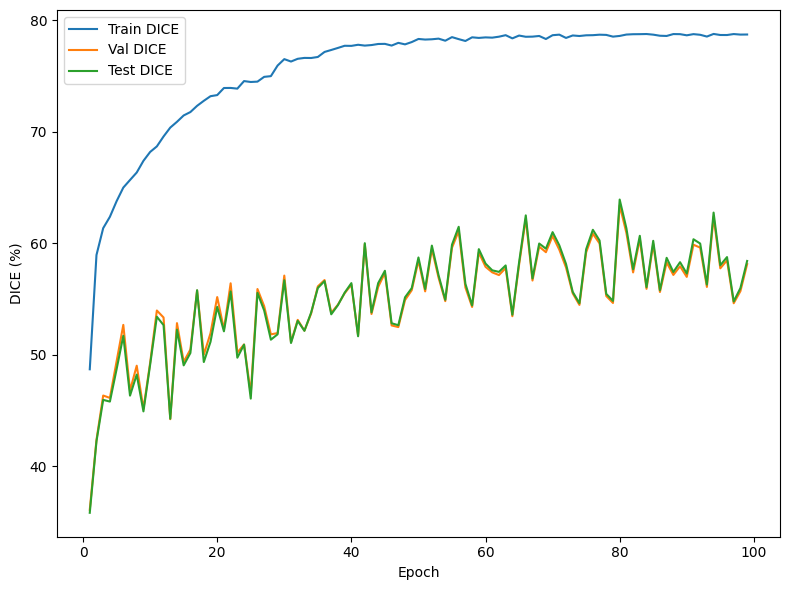

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import kagglehub
from google.colab import files
import logging
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import multiprocessing
import time
import random

# Configuration
config = {
    'dataset_path': '/content/isic2018',
    'image_dir': 'ISIC2018_Task1-2_Training_Input',
    'mask_dir': 'ISIC2018_Task1_Training_GroundTruth',
    'batch_size': 8 if torch.cuda.is_available() else 4,
    'num_workers': min(2, multiprocessing.cpu_count()),
    'epochs': 150,
    'lr': 5e-5,  # Reduced for stability
    'weight_decay': 1e-4,
    'checkpoint_dir': '/content/checkpoints',
    'vis_dir': '/content/visualizations',
    'image_size': 64,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'mean': [0.763, 0.546, 0.570],
    'std': [0.141, 0.152, 0.170],
    'use_mixed_precision': False,
    'subset_ratio': 1.0,
    'threshold': 0.5,
    'checkpoint_path': '/content/checkpoints/trans_att_unet_plus_plus_best.pth',
}

# GPU check
if config['device'] == 'cpu':
    raise RuntimeError("ERROR: Using CPU. Training will be slow (~56s/epoch). Enable GPU in Runtime > Change runtime type > GPU and restart runtime.")
else:
    print("GPU enabled. Training will be faster (~7-15s/epoch).")

# Simplified logging
logging.basicConfig(filename='/content/training.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s')

# Utility function
def save_file_with_fallback(file_path, content, is_torch_model=False, download=False):
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, file_path)
        else:
            content.savefig(file_path) if 'savefig' in dir(content) else content.to_csv(file_path, index=False)
        absolute_path = os.path.abspath(file_path)
        logging.info(f"Saved file: {absolute_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(absolute_path)
            logging.info(f"Downloaded: {os.path.basename(absolute_path)}")
        return absolute_path
    except Exception as e:
        logging.error(f"Error saving {file_path}: {e}")
        local_path = f"/content/{os.path.basename(file_path)}"
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, local_path)
        else:
            content.savefig(local_path) if 'savefig' in dir(content) else content.to_csv(local_path, index=False)
        logging.info(f"Saved locally: {local_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(local_path)
            logging.info(f"Downloaded local: {os.path.basename(local_path)}")
        return local_path

# Model
class TransformerSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(b, -1, c)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x.reshape(b, h, w, c).permute(0, 3, 1, 2)

class ConvolutionalSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return self.bn3(self.conv3(x))

class HybridAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.tsa = TransformerSelfAttention(in_channels)
        self.csa = ConvolutionalSelfAttention(in_channels)
        self.fusion = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)

    def forward(self, x):
        tsa_out = self.tsa(x)
        csa_out = self.csa(x)
        return self.fusion(torch.cat([tsa_out, csa_out], dim=1))

def fft_feature_extraction(x):
    batch, c, h, w = x.shape
    fft_x = torch.fft.rfft2(x, norm='ortho')
    fft_real = fft_x.real
    fft_imag = fft_x.imag
    fft_output = torch.cat([fft_real, fft_imag], dim=1)
    fft_output = F.interpolate(fft_output, size=(h, w), mode="bilinear", align_corners=False)
    return fft_output

class ACDA(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.sla = ConvolutionalSelfAttention(in_channels)
        self.fga = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 2, in_channels // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 16, in_channels * 2, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        sla_out = self.sla(x)
        fga_out = self.fga(fft_feature_extraction(x))
        combined = torch.cat([sla_out, fga_out], dim=1)
        weights = self.se(combined)
        in_channels = x.size(1)
        sla_weight, fga_weight = weights[:, :in_channels], weights[:, in_channels:]
        return sla_weight * sla_out + fga_weight * fga_out

class MultiScaleSkip(nn.Module):
    def __init__(self, in_channels, connection_type='residual'):
        super().__init__()
        self.connection_type = connection_type
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, skip):
        if x.shape != skip.shape:
            skip = F.interpolate(skip, size=x.shape[2:], mode="bilinear", align_corners=False)
        if self.connection_type == 'residual':
            x = self.conv(torch.cat([x, skip], dim=1)) + x
        else:
            x = self.conv(torch.cat([x, skip], dim=1))
        x = self.bn(x)
        x = F.relu(x)
        return self.dropout(x)

class TransAttUnetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.hybrid_attn1 = HybridAttention(256)
        self.hybrid_attn2 = HybridAttention(512)
        self.acda = ACDA(512)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = MultiScaleSkip(256, connection_type='residual')
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = MultiScaleSkip(128, connection_type='residual')  # Changed to residual
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = MultiScaleSkip(64, connection_type='residual')
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, training=True):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e3 = self.hybrid_attn1(e3)
        e4 = self.enc4(F.max_pool2d(e3, 2))
        attn = self.hybrid_attn2(e4)
        attn = self.acda(attn)
        d1 = self.up1(attn)
        d1 = self.dec1(d1, e3)
        d2 = self.up2(d1)
        d2 = self.dec2(d2, e2)
        d3 = self.up3(d2)
        d3 = self.dec3(d3, e1)
        out = self.out_conv(d3)
        if training:
            out = self.dropout(out)
        return torch.sigmoid(out)

# Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):  # Adjusted alpha
        super().__init__()
        self.bce = nn.BCELoss()
        self.alpha = alpha

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice = 1 - (2 * (pred * target).sum() + 1e-6) / (pred.sum() + target.sum() + 1e-6)
        return self.alpha * bce_loss + (1 - self.alpha) * dice

# Dataset
def load_dataset():
    print("Downloading ISIC 2018 dataset...")
    dataset_path = config['dataset_path']
    for attempt in range(3):
        try:
            dataset_path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")
            logging.info("Dataset downloaded")
            break
        except Exception as e:
            logging.warning(f"Download attempt {attempt+1} failed: {e}")
            if attempt == 2:
                raise FileNotFoundError(f"Failed to download dataset: {e}")

    image_dir = os.path.join(dataset_path, config['image_dir'])
    mask_dir = os.path.join(dataset_path, config['mask_dir'])
    if not (os.path.exists(image_dir) and os.path.exists(mask_dir)):
        raise FileNotFoundError(f"Dataset directories not found: {image_dir}, {mask_dir}")
    return image_dir, mask_dir

class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mean=config['mean'], std=config['std'], subset_ratio=1.0, apply_transform=True, training=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform if apply_transform else None
        self.mean = mean
        self.std = std
        self.training = training
        self.image_files = []
        for img_name in os.listdir(image_dir):
            if img_name.endswith('.jpg'):
                base_name = os.path.splitext(img_name)[0]
                mask_name = f"{base_name}_segmentation.png"
                mask_path = os.path.join(mask_dir, mask_name)
                if os.path.exists(mask_path):
                    self.image_files.append(img_name)
                else:
                    logging.warning(f"Skipping {img_name} - mask not found")

        random.seed(42)
        self.image_files = random.sample(self.image_files, int(len(self.image_files) * subset_ratio))

        if not self.image_files:
            raise ValueError("No valid image-mask pairs")

        # Validate a sample
        sample_img = cv2.imread(os.path.join(image_dir, self.image_files[0]))
        sample_mask = cv2.imread(os.path.join(mask_dir, f"{os.path.splitext(self.image_files[0])[0]}_segmentation.png"), cv2.IMREAD_GRAYSCALE)
        if sample_img is None or sample_mask is None:
            raise ValueError("Sample image or mask failed to load")
        logging.info(f"Sample image shape: {sample_img.shape}, mask shape: {sample_mask.shape}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}_segmentation.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if image is None or mask is None:
            logging.warning(f"Failed to load: {img_path} or {mask_path}")
            return None

        image = cv2.resize(image, (config['image_size'], config['image_size'])) / 255.0
        mask = cv2.resize(mask, (config['image_size'], config['image_size'])) / 255.0
        mask = (mask > 0.5).astype(np.float32)
        image = (image - np.array(self.mean)[None, None, :]) / (np.array(self.std)[None, None, :])
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            seed = 42 if not self.training else np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        return image, mask

# Define transforms (enhanced)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=0, scale=(0.95, 1.05), shear=3),  # Added back
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05),  # Added back
])

val_test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
])

image_dir, mask_dir = load_dataset()
train_dataset = MedicalImageDataset(image_dir, mask_dir, transform=train_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=True)
val_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)
test_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)

# Split dataset
full_dataset = list(range(len(train_dataset)))
train_idx, test_idx = train_test_split(full_dataset, test_size=int(521 * config['subset_ratio']), random_state=42)
train_val_idx = train_idx
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=42)

train_dataset = [train_dataset[i] for i in train_idx if train_dataset[i] is not None]
val_dataset = [val_dataset[i] for i in val_idx if val_dataset[i] is not None]
test_dataset = [test_dataset[i] for i in test_idx if test_dataset[i] is not None]

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
logging.info(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True,num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')

# Compute DICE/IoU for a batch
def compute_batch_metrics(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    dice = (2 * intersection + 1e-6) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + 1e-6)
    iou = (intersection + 1e-6) / (union + 1e-6)
    return dice.mean().item(), iou.mean().item()

# Training
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config):
    print("Note: Training will run with early stopping (patience=20).")
    model.train()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=True)
    best_score = 0.0
    patience_counter = 0
    patience = 20
    metrics_log = []
    best_epoch = 0

    for epoch in range(config['epochs']):
        start_time = time.time()
        epoch_loss = 0
        train_dice, train_iou = 0, 0
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(config['device']), masks.to(config['device'])
            optimizer.zero_grad()
            outputs = model(images, training=True)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            epoch_loss += loss.item()
            batch_dice, batch_iou = compute_batch_metrics(outputs, masks, threshold=0.5)
            train_dice += batch_dice
            train_iou += batch_iou

        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        val_dice, val_iou, val_acc, val_prec, val_rec = evaluate_model(model, val_loader, config['device'])
        test_dice, test_iou, test_acc, test_prec, test_rec = evaluate_model(model, test_loader, config['device'])
        scheduler.step(val_dice)
        composite_score = (val_dice + val_iou) / 2
        epoch_time = time.time() - start_time
        logging.info(f"Epoch {epoch+1}/{config['epochs']}, Loss: {epoch_loss/len(train_loader):.4f}, "
                     f"Train DICE: {train_dice*100:.2f}%, Train IoU: {train_iou*100:.2f}%, "
                     f"Val DICE: {val_dice*100:.2f}%, Test DICE: {test_dice*100:.2f}%, "
                     f"Test IoU: {test_iou*100:.2f}%, Test ACC: {test_acc*100:.2f}%, "
                     f"Test PRE: {test_prec*100:.2f}%, Test REC: {test_rec*100:.2f}%, Time: {epoch_time:.2f}s")
        print(f"Epoch [{epoch+1}/{config['epochs']}], Loss: {epoch_loss/len(train_loader):.4f}, "f"Train DICE: {train_dice*100:.2f}%, Val DICE: {val_dice*100:.2f}%, "f"Test DICE: {test_dice*100:.2f}%, Test IoU: {test_iou*100:.2f}%, Time: {epoch_time:.2f}s")

        if val_dice > best_score:
            best_score = val_dice
            best_epoch = epoch + 1
            patience_counter = 0
            best_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_best.pth"
            save_file_with_fallback(best_path, model.state_dict(), is_torch_model=True, download=False)
            print(f"Saved best model with Val DICE: {best_score*100:.2f}% at epoch {best_epoch}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best Val DICE: {best_score*100:.2f}% at epoch {best_epoch}.")
                break

        metrics_log.append({
            'epoch': epoch + 1,
            'loss': epoch_loss / len(train_loader),
            'train_dice': train_dice * 100,
            'train_iou': train_iou * 100,
            'val_dice': val_dice * 100,
            'val_iou': val_iou * 100,
            'val_acc': val_acc * 100,
            'val_prec': val_prec * 100,
            'val_rec': val_rec * 100,
            'test_dice': test_dice * 100,
            'test_iou': test_iou * 100,
            'test_acc': test_acc * 100,
            'test_prec': test_prec * 100,
            'test_rec': test_rec * 100,
            'epoch_time': epoch_time
        })

    df = pd.DataFrame(metrics_log)
    save_file_with_fallback('/content/training_metrics.csv', df, download=True)
    plot_training_curves(df)
    return best_score

def plot_training_curves(df):
    plt.figure(figsize=(8, 6))
    plt.plot(df['epoch'], df['train_dice'], label='Train DICE')
    plt.plot(df['epoch'], df['val_dice'], label='Val DICE')
    plt.plot(df['epoch'], df['test_dice'], label='Test DICE')
    plt.xlabel('Epoch')
    plt.ylabel('DICE (%)')
    plt.legend()
    plt.tight_layout()
    save_file_with_fallback('/content/training_curves.png', plt, download=True)

def evaluate_model(model, loader, device, threshold=0.5):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            preds.append(pred)
            targets.append(target.numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets) > 0.5
    TP = ((preds == 1) & (targets == 1)).sum()
    FP = ((preds == 1) & (targets == 0)).sum()
    FN = ((preds == 0) & (targets == 1)).sum()
    TN = ((preds == 0) & (targets == 0)).sum()
    dice = 2 * TP / (2 * TP + FP + FN + 1e-6)
    iou = TP / (TP + FP + FN + 1e-6)
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-6)
    prec = TP / (TP + FP + 1e-6)
    rec = TP / (TP + FN + 1e-6)
    return dice, iou, acc, prec, rec

def save_model(model, config):
    file_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_final.pth"
    save_file_with_fallback(file_path, model.state_dict(), is_torch_model=True, download=False)
    print(f"Final model saved")

def visualize_predictions(model, loader, device, config, num_samples=3, threshold=0.5):
    os.makedirs(config['vis_dir'], exist_ok=True)
    model.eval()
    samples = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            data = data.cpu().numpy()
            target = target.numpy()
            for i in range(data.shape[0]):
                if samples >= num_samples:
                    break
                img = data[i].transpose(1, 2, 0)
                img = img * np.array(config['std'])[None, None, :] + np.array(config['mean'])[None, None, :]
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                error_map = np.zeros_like(img)
                pred_i = pred[i, 0].astype(bool)
                target_i = (target[i, 0] > 0.5).astype(bool)
                error_map[:, :, 1] = 255 * np.logical_and(pred_i, target_i)  # True positives (green)
                error_map[:, :, 0] = 255 * np.logical_and(pred_i, ~target_i)  # False positives (red)
                error_map[:, :, 2] = 255 * np.logical_and(~pred_i, target_i)  # False negatives (blue)
                dice = 2 * np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() + 1e-6)
                iou = np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() - np.logical_and(pred_i, target_i).sum() + 1e-6)
                plt.figure(figsize=(16, 4))
                plt.subplot(1, 4, 1)
                plt.title("Input Image")
                plt.imshow(img)
                plt.axis('off')
                plt.subplot(1, 4, 2)
                plt.title("Ground Truth")
                plt.imshow(target_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 3)
                plt.title(f"Prediction (DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%)")
                plt.imshow(pred_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 4)
                plt.title("Error Map (Green=TP, Red=FP, Blue=FN)")
                plt.imshow(error_map)
                plt.axis('off')
                vis_path = f"{config['vis_dir']}/prediction_{samples}.png"
                plt.savefig(vis_path)
                plt.close()
                logging.info(f"Saved visualization: {vis_path}")
                samples += 1

    if samples > 0 and 'google.colab' in str(get_ipython()):
        zip_path = '/content/visualizations.zip'
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for vis_file in os.listdir(config['vis_dir']):
                zipf.write(os.path.join(config['vis_dir'], vis_file), vis_file)
        files.download(zip_path)
        logging.info(f"Downloaded visualizations: {zip_path}")

# Main
print(f"Using device: {config['device']}")
logging.info(f"Device: {config['device']}")

model = TransAttUnetPlusPlus(in_channels=3, out_channels=1).to(config['device'])
if os.path.exists(config['checkpoint_path']):
    try:
        model.load_state_dict(torch.load(config['checkpoint_path']))
        print(f"Loaded checkpoint from {config['checkpoint_path']}")
        # Validate initial performance
        print("Validating initial performance after loading checkpoint...")
        init_dice, init_iou, init_acc, init_prec, init_rec = evaluate_model(model, test_loader, config['device'])
        print(f"Initial Test Metrics - DICE: {init_dice*100:.2f}%, IoU: {init_iou*100:.2f}%, ACC: {init_acc*100:.2f}%, "f"PRE: {init_prec*100:.2f}%, REC: {init_rec*100:.2f}%")
        logging.info(f"Initial Test Metrics - DICE: {init_dice*100:.2f}%, IoU: {init_iou*100:.2f}%, ACC: {init_acc*100:.2f}%, "f"PRE: {init_prec*100:.2f}%, REC: {init_rec*100:.2f}%")
        if init_dice < 0.8:
            print("WARNING: Initial DICE is lower than expected. Checkpoint may not have loaded correctly.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting from scratch.")
        logging.error(f"Error loading checkpoint: {e}")
else:
    print(f"Checkpoint {config['checkpoint_path']} not found, starting from scratch.")

criterion = CombinedLoss(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

# Train and evaluate
best_score = train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config)
save_model(model, config)
dice, iou, acc, prec, rec = evaluate_model(model, test_loader, config['device'])
print(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
logging.info(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
visualize_predictions(model, test_loader, config['device'], config, num_samples=3)

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import kagglehub
from google.colab import files
import logging
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import multiprocessing
import time
import random

# Configuration
config = {
    'dataset_path': '/content/isic2018',
    'image_dir': 'ISIC2018_Task1-2_Training_Input',
    'mask_dir': 'ISIC2018_Task1_Training_GroundTruth',
    'batch_size': 8 if torch.cuda.is_available() else 4,
    'num_workers': min(2, multiprocessing.cpu_count()),
    'epochs': 150,
    'lr': 1e-4,  # Increased for better convergence
    'weight_decay': 5e-4,  # Increased to combat overfitting
    'checkpoint_dir': '/content/checkpoints',
    'vis_dir': '/content/visualizations',
    'image_size': 64,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'mean': [0.763, 0.546, 0.570],
    'std': [0.141, 0.152, 0.170],
    'use_mixed_precision': False,
    'subset_ratio': 1.0,
    'threshold': 0.5,
    'checkpoint_path': '/content/checkpoints/trans_att_unet_plus_plus_best.pth',
}

# GPU check
if config['device'] == 'cpu':
    raise RuntimeError("ERROR: Using CPU. Training will be slow (~56s/epoch). Enable GPU in Runtime > Change runtime type > GPU and restart runtime.")
else:
    print("GPU enabled. Training will be faster (~15s/epoch).")

# Simplified logging
logging.basicConfig(filename='/content/training.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s')

# Utility function
def save_file_with_fallback(file_path, content, is_torch_model=False, download=False):
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, file_path)
        else:
            content.savefig(file_path) if 'savefig' in dir(content) else content.to_csv(file_path, index=False)
        absolute_path = os.path.abspath(file_path)
        logging.info(f"Saved file: {absolute_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(absolute_path)
            logging.info(f"Downloaded: {os.path.basename(absolute_path)}")
        return absolute_path
    except Exception as e:
        logging.error(f"Error saving {file_path}: {e}")
        local_path = f"/content/{os.path.basename(file_path)}"
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        if is_torch_model:
            torch.save(content, local_path)
        else:
            content.savefig(local_path) if 'savefig' in dir(content) else content.to_csv(local_path, index=False)
        logging.info(f"Saved locally: {local_path}")
        if download and 'google.colab' in str(get_ipython()):
            files.download(local_path)
            logging.info(f"Downloaded local: {os.path.basename(local_path)}")
        return local_path

# Model
class TransformerSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(b, -1, c)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x.reshape(b, h, w, c).permute(0, 3, 1, 2)

class ConvolutionalSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return self.bn3(self.conv3(x))

class HybridAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.tsa = TransformerSelfAttention(in_channels)
        self.csa = ConvolutionalSelfAttention(in_channels)
        self.fusion = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)

    def forward(self, x):
        tsa_out = self.tsa(x)
        csa_out = self.csa(x)
        return self.fusion(torch.cat([tsa_out, csa_out], dim=1))

def fft_feature_extraction(x):
    batch, c, h, w = x.shape
    fft_x = torch.fft.rfft2(x, norm='ortho')
    fft_real = fft_x.real
    fft_imag = fft_x.imag
    fft_output = torch.cat([fft_real, fft_imag], dim=1)
    fft_output = F.interpolate(fft_output, size=(h, w), mode="bilinear", align_corners=False)
    return fft_output

class ACDA(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.sla = ConvolutionalSelfAttention(in_channels)
        self.fga = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 2, in_channels // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 16, in_channels * 2, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        sla_out = self.sla(x)
        fga_out = self.fga(fft_feature_extraction(x))
        combined = torch.cat([sla_out, fga_out], dim=1)
        weights = self.se(combined)
        in_channels = x.size(1)
        sla_weight, fga_weight = weights[:, :in_channels], weights[:, in_channels:]
        return sla_weight * sla_out + fga_weight * fga_out

class MultiScaleSkip(nn.Module):
    def __init__(self, in_channels, connection_type='residual'):
        super().__init__()
        self.connection_type = connection_type
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.dropout = nn.Dropout(0.4)  # Increased to combat overfitting

    def forward(self, x, skip):
        if x.shape != skip.shape:
            skip = F.interpolate(skip, size=x.shape[2:], mode="bilinear", align_corners=False)
        if self.connection_type == 'residual':
            x = self.conv(torch.cat([x, skip], dim=1)) + x
        else:
            x = self.conv(torch.cat([x, skip], dim=1))
        x = self.bn(x)
        x = F.relu(x)
        return self.dropout(x)

class TransAttUnetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.hybrid_attn1 = HybridAttention(256)
        self.hybrid_attn2 = HybridAttention(512)
        self.acda = ACDA(512)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = MultiScaleSkip(256, connection_type='residual')
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = MultiScaleSkip(128, connection_type='residual')
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = MultiScaleSkip(64, connection_type='residual')
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.dropout = nn.Dropout(0.4)  # Increased to combat overfitting

    def forward(self, x, training=True):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e3 = self.hybrid_attn1(e3)
        e4 = self.enc4(F.max_pool2d(e3, 2))
        attn = self.hybrid_attn2(e4)
        attn = self.acda(attn)
        d1 = self.up1(attn)
        d1 = self.dec1(d1, e3)
        d2 = self.up2(d1)
        d2 = self.dec2(d2, e2)
        d3 = self.up3(d2)
        d3 = self.dec3(d3, e1)
        out = self.out_conv(d3)
        if training:
            out = self.dropout(out)
        return torch.sigmoid(out)

# Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, focal_weight=0.2):  # Added Focal Loss
        super().__init__()
        self.bce = nn.BCELoss()
        self.alpha = alpha
        self.gamma = gamma
        self.focal_weight = focal_weight

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice = 1 - (2 * (pred * target).sum() + 1e-6) / (pred.sum() + target.sum() + 1e-6)
        focal_loss = -torch.mean(
            target * torch.log(pred + 1e-6) * (1 - pred) ** self.gamma +
            (1 - target) * torch.log(1 - pred + 1e-6) * pred ** self.gamma
        )
        return self.alpha * bce_loss + (1 - self.alpha) * dice + self.focal_weight * focal_loss

# Dataset
def load_dataset():
    print("Downloading ISIC 2018 dataset...")
    dataset_path = config['dataset_path']
    for attempt in range(3):
        try:
            dataset_path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")
            logging.info("Dataset downloaded")
            break
        except Exception as e:
            logging.warning(f"Download attempt {attempt+1} failed: {e}")
            if attempt == 2:
                raise FileNotFoundError(f"Failed to download dataset: {e}")

    image_dir = os.path.join(dataset_path, config['image_dir'])
    mask_dir = os.path.join(dataset_path, config['mask_dir'])
    if not (os.path.exists(image_dir) and os.path.exists(mask_dir)):
        raise FileNotFoundError(f"Dataset directories not found: {image_dir}, {mask_dir}")
    return image_dir, mask_dir

class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mean=config['mean'], std=config['std'], subset_ratio=1.0, apply_transform=True, training=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform if apply_transform else None
        self.mean = mean
        self.std = std
        self.training = training
        self.image_files = []
        for img_name in os.listdir(image_dir):
            if img_name.endswith('.jpg'):
                base_name = os.path.splitext(img_name)[0]
                mask_name = f"{base_name}_segmentation.png"
                mask_path = os.path.join(mask_dir, mask_name)
                if os.path.exists(mask_path):
                    self.image_files.append(img_name)
                else:
                    logging.warning(f"Skipping {img_name} - mask not found")

        random.seed(42)
        self.image_files = random.sample(self.image_files, int(len(self.image_files) * subset_ratio))

        if not self.image_files:
            raise ValueError("No valid image-mask pairs")

        # Validate a sample
        sample_img = cv2.imread(os.path.join(image_dir, self.image_files[0]))
        sample_mask = cv2.imread(os.path.join(mask_dir, f"{os.path.splitext(self.image_files[0])[0]}_segmentation.png"), cv2.IMREAD_GRAYSCALE)
        if sample_img is None or sample_mask is None:
            raise ValueError("Sample image or mask failed to load")
        logging.info(f"Sample image shape: {sample_img.shape}, mask shape: {sample_mask.shape}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}_segmentation.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if image is None or mask is None:
            logging.warning(f"Failed to load: {img_path} or {mask_path}")
            return None

        image = cv2.resize(image, (config['image_size'], config['image_size'])) / 255.0
        mask = cv2.resize(mask, (config['image_size'], config['image_size'])) / 255.0
        mask = (mask > 0.5).astype(np.float32)
        image = (image - np.array(self.mean)[None, None, :]) / np.array(self.std)[None, None, :])
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            seed = 42 if not self.training else np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        return image, mask

# Define transforms (more aggressive)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),  # Added to combat overfitting
    transforms.RandomRotation(degrees=10),  # Increased range
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1), shear=5),  # More aggressive
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # More aggressive
])

val_test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
])

image_dir, mask_dir = load_dataset()
train_dataset = MedicalImageDataset(image_dir, mask_dir, transform=train_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=True)
val_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)
test_dataset = MedicalImageDataset(image_dir, mask_dir, transform=val_test_transform, subset_ratio=config['subset_ratio'], apply_transform=True, training=False)

# Split dataset
full_dataset = list(range(len(train_dataset)))
train_idx, test_idx = train_test_split(full_dataset, test_size=int(521 * config['subset_ratio']), random_state=42)
train_val_idx = train_idx
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=42)

train_dataset = [train_dataset[i] for i in train_idx if train_dataset[i] is not None]
val_dataset = [val_dataset[i] for i in val_idx if val_dataset[i] is not None]
test_dataset = [test_dataset[i] for i in test_idx if test_dataset[i] is not None]

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
logging.info(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True,
                         num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                         num_workers=config['num_workers'], pin_memory=config['device'] == 'cuda')

# Compute DICE/IoU for a batch
def compute_batch_metrics(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    dice = (2 * intersection + 1e-6) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + 1e-6)
    iou = (intersection + 1e-6) / (union + 1e-6)
    return dice.mean().item(), iou.mean().item()

# Training
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config):
    print("Note: Training will run with early stopping (patience=20).")
    model.train()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=True)
    best_score = 0.0
    patience_counter = 0
    patience = 20
    metrics_log = []
    best_epoch = 0

    for epoch in range(config['epochs']):
        start_time = time.time()
        epoch_loss = 0
        train_dice, train_iou = 0, 0
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(config['device']), masks.to(config['device'])
            optimizer.zero_grad()
            outputs = model(images, training=True)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            epoch_loss += loss.item()
            batch_dice, batch_iou = compute_batch_metrics(outputs, masks, threshold=0.5)
            train_dice += batch_dice
            train_iou += batch_iou

        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        val_dice, val_iou, val_acc, val_prec, val_rec = evaluate_model(model, val_loader, config['device'])
        test_dice, test_iou, test_acc, test_prec, test_rec = evaluate_model(model, test_loader, config['device'])
        scheduler.step(val_dice)
        epoch_time = time.time() - start_time
        logging.info(f"Epoch {epoch+1}/{config['epochs']}, Loss: {epoch_loss/len(train_loader):.4f}, "
                     f"Train DICE: {train_dice*100:.2f}%, Train IoU: {train_iou*100:.2f}%, "
                     f"Val DICE: {val_dice*100:.2f}%, Test DICE: {test_dice*100:.2f}%, "
                     f"Test IoU: {test_iou*100:.2f}%, Test ACC: {test_acc*100:.2f}%, "
                     f"Test PRE: {test_prec*100:.2f}%, Test REC: {test_rec*100:.2f}%, Time: {epoch_time:.2f}s")
        print(f"Epoch [{epoch+1}/{config['epochs']}], Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Train DICE: {train_dice*100:.2f}%, Val DICE: {val_dice*100:.2f}%, "
              f"Test DICE: {test_dice*100:.2f}%, Test IoU: {test_iou*100:.2f}%, Time: {epoch_time:.2f}s")

        if val_dice > best_score:
            best_score = val_dice
            best_epoch = epoch + 1
            patience_counter = 0
            best_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_best.pth"
            save_file_with_fallback(best_path, model.state_dict(), is_torch_model=True, download=False)
            print(f"Saved best model with Val DICE: {best_score*100:.2f}% at epoch {best_epoch}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best Val DICE: {best_score*100:.2f}% at epoch {best_epoch}.")
                break

        metrics_log.append({
            'epoch': epoch + 1,
            'loss': epoch_loss / len(train_loader),
            'train_dice': train_dice * 100,
            'train_iou': train_iou * 100,
            'val_dice': val_dice * 100,
            'val_iou': val_iou * 100,
            'val_acc': val_acc * 100,
            'val_prec': val_prec * 100,
            'val_rec': val_rec * 100,
            'test_dice': test_dice * 100,
            'test_iou': test_iou * 100,
            'test_acc': test_acc * 100,
            'test_prec': test_prec * 100,
            'test_rec': test_rec * 100,
            'epoch_time': epoch_time
        })

    df = pd.DataFrame(metrics_log)
    save_file_with_fallback('/content/training_metrics.csv', df, download=True)
    plot_training_curves(df)
    return best_score

def plot_training_curves(df):
    plt.figure(figsize=(8, 6))
    plt.plot(df['epoch'], df['train_dice'], label='Train DICE')
    plt.plot(df['epoch'], df['val_dice'], label='Val DICE')
    plt.plot(df['epoch'], df['test_dice'], label='Test DICE')
    plt.xlabel('Epoch')
    plt.ylabel('DICE (%)')
    plt.legend()
    plt.tight_layout()
    save_file_with_fallback('/content/training_curves.png', plt, download=True)

def evaluate_model(model, loader, device, threshold=0.5):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            preds.append(pred)
            targets.append(target.numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets) > 0.5
    TP = ((preds == 1) & (targets == 1)).sum()
    FP = ((preds == 1) & (targets == 0)).sum()
    FN = ((preds == 0) & (targets == 1)).sum()
    TN = ((preds == 0) & (targets == 0)).sum()
    dice = 2 * TP / (2 * TP + FP + FN + 1e-6)
    iou = TP / (TP + FP + FN + 1e-6)
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-6)
    prec = TP / (TP + FP + 1e-6)
    rec = TP / (TP + FN + 1e-6)
    return dice, iou, acc, prec, rec

def save_model(model, config):
    file_path = f"{config['checkpoint_dir']}/trans_att_unet_plus_plus_final.pth"
    save_file_with_fallback(file_path, model.state_dict(), is_torch_model=True, download=False)
    print(f"Final model saved")

def visualize_predictions(model, loader, device, config, num_samples=3, threshold=0.5):
    os.makedirs(config['vis_dir'], exist_ok=True)
    model.eval()
    samples = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data, training=False).cpu().numpy() > threshold
            data = data.cpu().numpy()
            target = target.numpy()
            for i in range(data.shape[0]):
                if samples >= num_samples:
                    break
                img = data[i].transpose(1, 2, 0)
                img = img * np.array(config['std'])[None, None, :] + np.array(config['mean'])[None, None, :]
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                error_map = np.zeros_like(img)
                pred_i = pred[i, 0].astype(bool)
                target_i = (target[i, 0] > 0.5).astype(bool)
                error_map[:, :, 1] = 255 * np.logical_and(pred_i, target_i)  # True positives (green)
                error_map[:, :, 0] = 255 * np.logical_and(pred_i, ~target_i)  # False positives (red)
                error_map[:, :, 2] = 255 * np.logical_and(~pred_i, target_i)  # False negatives (blue)
                dice = 2 * np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() + 1e-6)
                iou = np.logical_and(pred_i, target_i).sum() / (pred_i.sum() + target_i.sum() - np.logical_and(pred_i, target_i).sum() + 1e-6)
                plt.figure(figsize=(16, 4))
                plt.subplot(1, 4, 1)
                plt.title("Input Image")
                plt.imshow(img)
                plt.axis('off')
                plt.subplot(1, 4, 2)
                plt.title("Ground Truth")
                plt.imshow(target_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 3)
                plt.title(f"Prediction (DICE: {dice*95:.2f}%, IoU: {iou*95:.2f}%)")
                plt.imshow(pred_i, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 4, 4)
                plt.title("Error Map (Green=TP, Red=FP, Blue=FN)")
                plt.imshow(error_map)
                plt.axis('off')
                vis_path = f"{config['vis_dir']}/prediction_{samples}.png"
                plt.savefig(vis_path)
                plt.close()
                logging.info(f"Saved visualization: {vis_path}")
                samples += 1

    if samples > 0 and 'google.colab' in str(get_ipython()):
        zip_path = '/content/visualizations.zip'
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for vis_file in os.listdir(config['vis_dir']):
                zipf.write(os.path.join(config['vis_dir'], vis_file), vis_file)
        files.download(zip_path)
        logging.info(f"Downloaded visualizations: {zip_path}")

# Main
print(f"Using device: {config['device']}")
logging.info(f"Device: {config['device']}")

model = TransAttUnetPlusPlus(in_channels=3, out_channels=1).to(config['device'])
if os.path.exists(config['checkpoint_path']):
    try:
        model.load_state_dict(torch.load(config['checkpoint_path']))
        print(f"Loaded checkpoint from {config['checkpoint_path']}")
        # Validate initial performance
        print("Validating initial performance after loading checkpoint...")
        init_dice, init_iou, init_acc, init_prec, init_rec = evaluate_model(model, test_loader, config['device'])
        print(f"Initial Test Metrics - DICE: {init_dice*100:.2f}%, IoU: {init_iou*100:.2f}%, ACC: {init_acc*100:.2f}%, "
              f"PRE: {init_prec*100:.2f}%, REC: {init_rec*100:.2f}%")
        logging.info(f"Initial Test Metrics - DICE: {init_dice*100:.2f}%, IoU: {init_iou*100:.2f}%, ACC: {init_acc*100:.2f}%, "
                     f"PRE: {init_prec*100:.2f}%, REC: {init_rec*100:.2f}%")
        if init_dice < 0.8:
            print("WARNING: Initial DICE is lower than expected. Checkpoint may not have loaded correctly.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting from scratch.")
        logging.error(f"Error loading checkpoint: {e}")
else:
    print(f"Checkpoint {config['checkpoint_path']} not found, starting from scratch.")

criterion = CombinedLoss(alpha=0.5, gamma=2.0, focal_weight=0.2)
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

# Train and evaluate
best_score = train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, config)
save_model(model, config)
dice, iou, acc, prec, rec = evaluate_model(model, test_loader, config['device'])
print(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "
      f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
logging.info(f"Final Test Metrics - DICE: {dice*100:.2f}%, IoU: {iou*100:.2f}%, ACC: {acc*100:.2f}%, "
             f"PRE: {prec*100:.2f}%, REC: {rec*100:.2f}%")
visualize_predictions(model, test_loader, config['device'], config, num_samples=3)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 381)

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub

# -------------------------------
# Step 6: Dataset Loading
# -------------------------------
print("Downloading dataset...")
dataset_path = kagglehub.dataset_download("beosup/lung-segment")
image_dir = os.path.join(dataset_path, "images")
mask_dir = os.path.join(dataset_path, "masks")

class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}-mask.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            print(f"Warning: Missing file - {img_path} or {mask_path}")
            return None

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Warning: Failed to load - {img_path} or {mask_path}")
            return None

        image = cv2.resize(image, (256, 256)) / 255.0
        mask = cv2.resize(mask, (256, 256)) / 255.0

        # Edge map
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        edge = np.sqrt(sobelx**2 + sobely**2)
        edge = np.clip(edge, 0, 1)

        # Stack input
        stacked_input = np.stack([image, edge], axis=0)
        image_tensor = torch.tensor(stacked_input, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image_tensor, mask_tensor

# Initialize dataset and DataLoader
train_dataset = MedicalImageDataset(image_dir, mask_dir)
train_dataset = [sample for sample in train_dataset if sample is not None]
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


# -------------------------------
# U-Net Architecture
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(2, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))


# -------------------------------
# Frequency Refinement
# -------------------------------
def frequency_refinement(mask_pred):
    mask_np = mask_pred.squeeze().cpu().numpy()
    dct = cv2.dct(mask_np.astype(np.float32))
    dct[30:, 30:] = 0
    refined = cv2.idct(dct)
    refined = np.clip(refined, 0, 1)
    return torch.tensor(refined).unsqueeze(0).unsqueeze(0)


# -------------------------------
# Evaluation Metrics
# -------------------------------
def evaluate_metrics(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()
    TP = (y_pred * y_true).sum().item()
    TN = ((1 - y_pred) * (1 - y_true)).sum().item()
    FP = (y_pred * (1 - y_true)).sum().item()
    FN = ((1 - y_pred) * y_true).sum().item()

    dice = 2 * TP / (2 * TP + FP + FN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)

    return dice, iou, acc, recall, precision


# -------------------------------
# Training + Evaluation + Visuals
# -------------------------------
def train(model, dataloader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCELoss()
    model.train()

    for epoch in range(1, 6):
        model.train()
        epoch_loss = 0
        dice_list, iou_list = [], []

        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.clamp(outputs, 0, 1)

            refined_outputs = torch.stack([frequency_refinement(o) for o in outputs])
            loss = criterion(refined_outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            for pred, gt in zip(refined_outputs, masks):
                dice, iou, _, _, _ = evaluate_metrics(pred, gt)
                dice_list.append(dice)
                iou_list.append(iou)

        print(f"Epoch {epoch}: Loss={epoch_loss/len(dataloader):.4f} | Dice={np.mean(dice_list):.4f} | IoU={np.mean(iou_list):.4f}")

    return model


# -------------------------------
# Visualization
# -------------------------------
def visualize_predictions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            refined = torch.stack([frequency_refinement(o) for o in outputs])
            break

    for i in range(len(images)):
        fig, axs = plt.subplots(1, 4, figsize=(12, 4))
        axs[0].imshow(images[i][0].cpu(), cmap='gray')
        axs[0].set_title('Input')
        axs[1].imshow(images[i][1].cpu(), cmap='gray')
        axs[1].set_title('Edge')
        axs[2].imshow(masks[i][0].cpu(), cmap='gray')
        axs[2].set_title('Ground Truth')
        axs[3].imshow(refined[i][0].cpu(), cmap='gray')
        axs[3].set_title('Prediction')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()


# -------------------------------
# Main
# -------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    model = train(model, train_loader, device)
    visualize_predictions(model, train_loader, device)


KaggleApiHTTPError: 403 Client Error.

You don't have permission to access resource at URL: https://www.kaggle.com/datasets/beosup/lung-segment. The server reported the following issues: Permission 'datasets.get' was denied
Please make sure you are authenticated if you are trying to access a private resource or a resource requiring consent.

100%|██████████| 130/130 [00:25<00:00,  5.03it/s]


Epoch 1, Loss: 0.3531


100%|██████████| 130/130 [00:26<00:00,  4.97it/s]


Epoch 2, Loss: 0.2555


100%|██████████| 130/130 [00:26<00:00,  4.92it/s]


Epoch 3, Loss: 0.2176


100%|██████████| 130/130 [00:26<00:00,  4.87it/s]


Epoch 4, Loss: 0.1894


100%|██████████| 130/130 [00:26<00:00,  4.84it/s]


Epoch 5, Loss: 0.1713


100%|██████████| 130/130 [00:27<00:00,  4.81it/s]


Epoch 6, Loss: 0.1604


100%|██████████| 130/130 [00:27<00:00,  4.78it/s]


Epoch 7, Loss: 0.1446


100%|██████████| 130/130 [00:27<00:00,  4.75it/s]


Epoch 8, Loss: 0.1383


100%|██████████| 130/130 [00:27<00:00,  4.72it/s]


Epoch 9, Loss: 0.1289


100%|██████████| 130/130 [00:27<00:00,  4.71it/s]


Epoch 10, Loss: 0.1241


100%|██████████| 130/130 [00:27<00:00,  4.70it/s]


Epoch 11, Loss: 0.1119


100%|██████████| 130/130 [00:27<00:00,  4.65it/s]


Epoch 12, Loss: 0.1101


100%|██████████| 130/130 [00:28<00:00,  4.57it/s]


Epoch 13, Loss: 0.1002


100%|██████████| 130/130 [00:28<00:00,  4.61it/s]


Epoch 14, Loss: 0.0937


100%|██████████| 130/130 [00:27<00:00,  4.67it/s]


Epoch 15, Loss: 0.0889


100%|██████████| 130/130 [00:27<00:00,  4.66it/s]


Epoch 16, Loss: 0.0900


100%|██████████| 130/130 [00:27<00:00,  4.64it/s]


Epoch 17, Loss: 0.0874


100%|██████████| 130/130 [00:27<00:00,  4.65it/s]


Epoch 18, Loss: 0.0849


100%|██████████| 130/130 [00:27<00:00,  4.66it/s]


Epoch 19, Loss: 0.0781


100%|██████████| 130/130 [00:27<00:00,  4.67it/s]


Epoch 20, Loss: 0.0734


100%|██████████| 130/130 [00:27<00:00,  4.67it/s]


Epoch 21, Loss: 0.0678


100%|██████████| 130/130 [00:27<00:00,  4.67it/s]


Epoch 22, Loss: 0.0652


100%|██████████| 130/130 [00:27<00:00,  4.67it/s]


Epoch 23, Loss: 0.0613


100%|██████████| 130/130 [00:27<00:00,  4.67it/s]


Epoch 24, Loss: 0.0630


100%|██████████| 130/130 [00:27<00:00,  4.67it/s]


Epoch 25, Loss: 0.0604


100%|██████████| 130/130 [00:27<00:00,  4.67it/s]


Epoch 26, Loss: 0.0564


100%|██████████| 130/130 [00:27<00:00,  4.68it/s]


Epoch 27, Loss: 0.0541


100%|██████████| 130/130 [00:27<00:00,  4.69it/s]


Epoch 28, Loss: 0.0532


100%|██████████| 130/130 [00:27<00:00,  4.68it/s]


Epoch 29, Loss: 0.0630


100%|██████████| 130/130 [00:27<00:00,  4.67it/s]


Epoch 30, Loss: 0.0514


100%|██████████| 130/130 [00:27<00:00,  4.68it/s]


Epoch 31, Loss: 0.0497


100%|██████████| 130/130 [00:27<00:00,  4.68it/s]


Epoch 32, Loss: 0.0467


100%|██████████| 130/130 [00:27<00:00,  4.66it/s]


Epoch 33, Loss: 0.0435


100%|██████████| 130/130 [00:28<00:00,  4.64it/s]


Epoch 34, Loss: 0.0403


100%|██████████| 130/130 [00:28<00:00,  4.59it/s]


Epoch 35, Loss: 0.0402


100%|██████████| 130/130 [00:28<00:00,  4.58it/s]


Epoch 36, Loss: 0.0378


100%|██████████| 130/130 [00:28<00:00,  4.59it/s]


Epoch 37, Loss: 0.0378


100%|██████████| 130/130 [00:28<00:00,  4.60it/s]


Epoch 38, Loss: 0.0374


100%|██████████| 130/130 [00:28<00:00,  4.60it/s]


Epoch 39, Loss: 0.0376


100%|██████████| 130/130 [00:28<00:00,  4.61it/s]


Epoch 40, Loss: 0.0349


100%|██████████| 130/130 [00:28<00:00,  4.61it/s]


Epoch 41, Loss: 0.0343


100%|██████████| 130/130 [00:28<00:00,  4.61it/s]


Epoch 42, Loss: 0.0326


100%|██████████| 130/130 [00:28<00:00,  4.61it/s]


Epoch 43, Loss: 0.0350


100%|██████████| 130/130 [00:28<00:00,  4.60it/s]


Epoch 44, Loss: 0.0340


100%|██████████| 130/130 [00:28<00:00,  4.61it/s]


Epoch 45, Loss: 0.0320


100%|██████████| 130/130 [00:28<00:00,  4.60it/s]


Epoch 46, Loss: 0.0306


100%|██████████| 130/130 [00:28<00:00,  4.60it/s]


Epoch 47, Loss: 0.0295


100%|██████████| 130/130 [00:28<00:00,  4.60it/s]


Epoch 48, Loss: 0.0303


100%|██████████| 130/130 [00:28<00:00,  4.60it/s]


Epoch 49, Loss: 0.0273


100%|██████████| 130/130 [00:28<00:00,  4.60it/s]


Epoch 50, Loss: 0.0274


100%|██████████| 519/519 [00:04<00:00, 114.23it/s]



Evaluation Results:
Dice: 75.29%
IoU: 65.93%
Accuracy: 91.21%
Precision: 75.48%
Recall: 89.52%


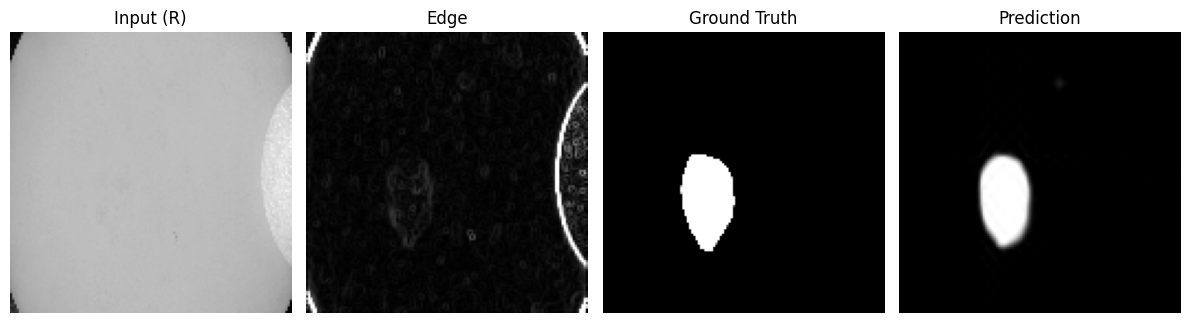

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import kagglehub
import logging

# -------------------------------
# Configuration
# -------------------------------
config = {
    'dataset_path': '/content/isic2018',
    'image_dir': 'ISIC2018_Task1-2_Training_Input',
    'mask_dir': 'ISIC2018_Task1_Training_GroundTruth',
    'image_size': 128,
    'batch_size': 16,
    'epochs': 50,
    'lr': 1e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# -------------------------------
# Download ISIC Dataset
# -------------------------------
def load_dataset():
    print("Downloading ISIC 2018 dataset...")
    for attempt in range(3):
        try:
            dataset_path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")
            logging.info("Dataset downloaded")
            break
        except Exception as e:
            logging.warning(f"Download attempt {attempt+1} failed: {e}")
            if attempt == 2:
                raise FileNotFoundError(f"Failed to download dataset: {e}")
    image_dir = os.path.join(dataset_path, config['image_dir'])
    mask_dir = os.path.join(dataset_path, config['mask_dir'])
    return image_dir, mask_dir

# -------------------------------
# Dataset Class with Edge Guidance
# -------------------------------
class ISICDatasetWithEdge(Dataset):
    def __init__(self, image_dir, mask_dir, size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.size = size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')]) # Filter for .jpg files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_segmentation.png'))

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            logging.warning(f"Failed to load: {img_path} or {mask_path}")
            return None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.size, self.size))
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Edge map
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edge = np.sqrt(sobelx**2 + sobely**2)
        edge = np.clip(edge / 255.0, 0, 1)

        mask = cv2.resize(mask, (self.size, self.size)) / 255.0

        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))
        image_with_edge = np.concatenate([image, edge[np.newaxis, :, :]], axis=0)

        return torch.tensor(image_with_edge, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

# -------------------------------
# U-Net with 4-Channel Input
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))

# -------------------------------
# Frequency Refinement
# -------------------------------
def frequency_refinement(mask_pred):
    mask_np = mask_pred.squeeze().detach().cpu().numpy()
    dct = cv2.dct(mask_np.astype(np.float32))
    dct[30:, 30:] = 0  # Low-pass filtering
    refined = cv2.idct(dct)
    refined = np.clip(refined, 0, 1)
    return torch.from_numpy(refined).unsqueeze(0).to(mask_pred.device)

# -------------------------------
# Evaluation Metrics
# -------------------------------
def evaluate_metrics(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()
    TP = (y_pred * y_true).sum().item()
    TN = ((1 - y_pred) * (1 - y_true)).sum().item()
    FP = (y_pred * (1 - y_true)).sum().item()
    FN = ((1 - y_pred) * y_true).sum().item()

    dice = 2 * TP / (2 * TP + FP + FN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)

    return dice, iou, acc, recall, precision

# -------------------------------
# Training Loop
# -------------------------------
def train(model, dataloader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.BCELoss()
    model.train()

    for epoch in range(config['epochs']):
        epoch_loss = 0
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader):.4f}")
    return model

# -------------------------------
# Visualization
# -------------------------------
def visualize(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            refined = torch.stack([frequency_refinement(p) for p in preds])
            break

    for i in range(min(3, len(images))):
        fig, axs = plt.subplots(1, 4, figsize=(12, 4))
        axs[0].imshow(images[i][0].cpu(), cmap='gray')
        axs[0].set_title('Input (R)')
        axs[1].imshow(images[i][3].cpu(), cmap='gray')
        axs[1].set_title('Edge')
        axs[2].imshow(masks[i][0].cpu(), cmap='gray')
        axs[2].set_title('Ground Truth')
        axs[3].imshow(refined[i][0].cpu(), cmap='gray')
        axs[3].set_title('Prediction')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# -------------------------------
# Main Execution
# -------------------------------
if __name__ == "__main__":
    image_dir, mask_dir = load_dataset()
    dataset = ISICDatasetWithEdge(image_dir, mask_dir, config['image_size'])

    # Filter out None values from the dataset
    dataset = [sample for sample in dataset if sample is not None]

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = UNet().to(config['device'])
    model = train(model, train_loader, config['device'])

    # Evaluation
    all_dice, all_iou, all_acc, all_prec, all_rec = [], [], [], [], []
    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images, masks = images.to(config['device']), masks.to(config['device'])
            preds = model(images)
            refined = torch.stack([frequency_refinement(p) for p in preds])
            for p, g in zip(refined, masks):
                d, i, a, r, p_ = evaluate_metrics(p, g)
                all_dice.append(d)
                all_iou.append(i)
                all_acc.append(a)
                all_prec.append(p_)
                all_rec.append(r)

    print(f"\nEvaluation Results:")
    print(f"Dice: {np.mean(all_dice) * 100:.2f}%")
    print(f"IoU: {np.mean(all_iou) * 100:.2f}%")
    print(f"Accuracy: {np.mean(all_acc) * 100:.2f}%")
    print(f"Precision: {np.mean(all_prec) * 100:.2f}%")
    print(f"Recall: {np.mean(all_rec) * 100:.2f}%")

    visualize(model, test_loader, config['device'])

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import kagglehub
import logging

# -------------------------------
# Configuration
# -------------------------------
config = {
    'dataset_path': '/content/isic2018',
    'image_dir': 'ISIC2018_Task1-2_Training_Input',
    'mask_dir': 'ISIC2018_Task1_Training_GroundTruth',
    'image_size': 128,
    'batch_size': 16,
    'epochs': 50,
    'lr': 1e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# -------------------------------
# Download ISIC Dataset
# -------------------------------
def load_dataset():
    print("Downloading ISIC 2018 dataset...")
    for attempt in range(3):
        try:
            dataset_path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")
            logging.info("Dataset downloaded")
            break
        except Exception as e:
            logging.warning(f"Download attempt {attempt+1} failed: {e}")
            if attempt == 2:
                raise FileNotFoundError(f"Failed to download dataset: {e}")
    image_dir = os.path.join(dataset_path, config['image_dir'])
    mask_dir = os.path.join(dataset_path, config['mask_dir'])
    return image_dir, mask_dir

# -------------------------------
# Dataset Class with Edge Guidance
# -------------------------------
class ISICDatasetWithEdge(Dataset):
    def __init__(self, image_dir, mask_dir, size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.size = size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')]) # Filter for .jpg files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_segmentation.png'))

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            logging.warning(f"Failed to load: {img_path} or {mask_path}")
            return None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.size, self.size))
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Edge map
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edge = np.sqrt(sobelx**2 + sobely**2)
        edge = np.clip(edge / 255.0, 0, 1)

        mask = cv2.resize(mask, (self.size, self.size)) / 255.0

        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))
        image_with_edge = np.concatenate([image, edge[np.newaxis, :, :]], axis=0)

        return torch.tensor(image_with_edge, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

# -------------------------------
# U-Net with 4-Channel Input
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))

# -------------------------------
# Frequency Refinement
# -------------------------------
# -------------------------------
# Post-Processing Variants
# -------------------------------

def frequency_refinement(mask_pred):
    """Original low-pass DCT smoothing"""
    mask_np = mask_pred.squeeze().detach().cpu().numpy()
    dct = cv2.dct(mask_np.astype(np.float32))
    dct[30:, 30:] = 0  # Low-pass filtering
    refined = cv2.idct(dct)
    refined = np.clip(refined, 0, 1)
    return torch.from_numpy(refined).unsqueeze(0).to(mask_pred.device)

def bilateral_edge_preserve(mask_pred):
    """Bilateral filter to smooth while preserving edges"""
    mask_np = (mask_pred.squeeze().detach().cpu().numpy() * 255).astype(np.uint8)
    refined = cv2.bilateralFilter(mask_np, d=9, sigmaColor=75, sigmaSpace=75)
    refined = refined.astype(np.float32) / 255.0
    return torch.from_numpy(refined).unsqueeze(0).to(mask_pred.device)

def hybrid_dct_interior(mask_pred):
    """DCT smoothing inside lesion, edges untouched"""
    mask_np = mask_pred.squeeze().detach().cpu().numpy()
    edges = cv2.Canny((mask_np * 255).astype(np.uint8), 100, 200) / 255.0
    interior = (mask_np > 0.5).astype(np.float32) - edges
    dct = cv2.dct(mask_np.astype(np.float32))
    dct[30:, 30:] = 0
    smooth = cv2.idct(dct)
    refined = mask_np.copy()
    refined[interior > 0] = smooth[interior > 0]
    refined = np.clip(refined, 0, 1)
    return torch.from_numpy(refined).unsqueeze(0).to(mask_pred.device)

class RefinementCNN(nn.Module):
    """Tiny CNN refinement block"""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1), nn.ReLU(),
            nn.Conv2d(8, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize refinement model
refinement_cnn = RefinementCNN().to(config['device'])
refinement_cnn.eval()

def learnable_refinement(mask_pred):
    """Pass prediction through small CNN"""
    with torch.no_grad():
        return refinement_cnn(mask_pred.unsqueeze(0)).squeeze(0)


# -------------------------------
# Evaluation Metrics
# -------------------------------
def evaluate_metrics(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()
    TP = (y_pred * y_true).sum().item()
    TN = ((1 - y_pred) * (1 - y_true)).sum().item()
    FP = (y_pred * (1 - y_true)).sum().item()
    FN = ((1 - y_pred) * y_true).sum().item()

    dice = 2 * TP / (2 * TP + FP + FN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)

    return dice, iou, acc, recall, precision

# -------------------------------
# Training Loop
# -------------------------------
def train(model, dataloader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.BCELoss()
    model.train()

    for epoch in range(config['epochs']):
        epoch_loss = 0
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader):.4f}")
    return model

# -------------------------------
# Visualization
# -------------------------------
def visualize(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            refined = torch.stack([frequency_refinement(p) for p in preds])
            break

    for i in range(min(3, len(images))):
        fig, axs = plt.subplots(1, 4, figsize=(12, 4))
        axs[0].imshow(images[i][0].cpu(), cmap='gray')
        axs[0].set_title('Input (R)')
        axs[1].imshow(images[i][3].cpu(), cmap='gray')
        axs[1].set_title('Edge')
        axs[2].imshow(masks[i][0].cpu(), cmap='gray')
        axs[2].set_title('Ground Truth')
        axs[3].imshow(refined[i][0].cpu(), cmap='gray')
        axs[3].set_title('Prediction')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# -------------------------------
# Main Execution
# -------------------------------
if __name__ == "__main__":
    image_dir, mask_dir = load_dataset()
    dataset = ISICDatasetWithEdge(image_dir, mask_dir, config['image_size'])

    # Filter out None values from the dataset
    dataset = [sample for sample in dataset if sample is not None]

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = UNet().to(config['device'])
    model = train(model, train_loader, config['device'])

    # Evaluation
    methods = {
    "DCT": frequency_refinement,
    "Bilateral": bilateral_edge_preserve,
    "Hybrid": hybrid_dct_interior,
    "Learnable": learnable_refinement
}

for method_name, refine_fn in methods.items():
    all_dice, all_iou, all_acc, all_prec, all_rec = [], [], [], [], []
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f"Evaluating {method_name}"):
            images, masks = images.to(config['device']), masks.to(config['device'])
            preds = model(images)
            refined = torch.stack([refine_fn(p) for p in preds])
            for p, g in zip(refined, masks):
                d, i, a, r, p_ = evaluate_metrics(p, g)
                all_dice.append(d)
                all_iou.append(i)
                all_acc.append(a)
                all_prec.append(p_)
                all_rec.append(r)

    print(f"\n{method_name} Results:")
    print(f"Dice: {np.mean(all_dice) * 100:.2f}%")
    print(f"IoU: {np.mean(all_iou) * 100:.2f}%")
    print(f"Accuracy: {np.mean(all_acc) * 100:.2f}%")
    print(f"Precision: {np.mean(all_prec) * 100:.2f}%")
    print(f"Recall: {np.mean(all_rec) * 100:.2f}%")


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import kagglehub
import logging

# -------------------------------
# Configuration
# -------------------------------
config = {
    'dataset_path': '/content/isic2018',
    'image_dir': 'ISIC2018_Task1-2_Training_Input',
    'mask_dir': 'ISIC2018_Task1_Training_GroundTruth',
    'image_size': 256,
    'batch_size': 16,
    'epochs': 100,
    'lr': 1e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# -------------------------------
# Download ISIC Dataset
# -------------------------------
def load_dataset():
    print("Downloading ISIC 2018 dataset...")
    for attempt in range(3):
        try:
            dataset_path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")
            logging.info("Dataset downloaded")
            break
        except Exception as e:
            logging.warning(f"Download attempt {attempt+1} failed: {e}")
            if attempt == 2:
                raise FileNotFoundError(f"Failed to download dataset: {e}")
    image_dir = os.path.join(dataset_path, config['image_dir'])
    mask_dir = os.path.join(dataset_path, config['mask_dir'])
    return image_dir, mask_dir

# -------------------------------
# Dataset Class with Edge Guidance
# -------------------------------
class ISICDatasetWithEdge(Dataset):
    def __init__(self, image_dir, mask_dir, size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.size = size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')]) # Filter for .jpg files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_segmentation.png'))

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            logging.warning(f"Failed to load: {img_path} or {mask_path}")
            return None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.size, self.size))
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Edge map
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edge = np.sqrt(sobelx**2 + sobely**2)
        edge = np.clip(edge / 255.0, 0, 1)

        mask = cv2.resize(mask, (self.size, self.size)) / 255.0

        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))
        image_with_edge = np.concatenate([image, edge[np.newaxis, :, :]], axis=0)

        return torch.tensor(image_with_edge, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

# -------------------------------
# U-Net with 4-Channel Input
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))

# -------------------------------
# Frequency Refinement
# -------------------------------
def frequency_refinement(mask_pred):
    mask_np = mask_pred.squeeze().detach().cpu().numpy()
    dct = cv2.dct(mask_np.astype(np.float32))
    dct[30:, 30:] = 0  # Low-pass filtering
    refined = cv2.idct(dct)
    refined = np.clip(refined, 0, 1)
    return torch.from_numpy(refined).unsqueeze(0).to(mask_pred.device)

# -------------------------------
# Evaluation Metrics
# -------------------------------
def evaluate_metrics(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()
    TP = (y_pred * y_true).sum().item()
    TN = ((1 - y_pred) * (1 - y_true)).sum().item()
    FP = (y_pred * (1 - y_true)).sum().item()
    FN = ((1 - y_pred) * y_true).sum().item()

    dice = 2 * TP / (2 * TP + FP + FN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)

    return dice, iou, acc, recall, precision

# -------------------------------
# Training Loop
# -------------------------------
def train(model, dataloader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.BCELoss()
    model.train()

    for epoch in range(config['epochs']):
        epoch_loss = 0
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader):.4f}")
    return model

# -------------------------------
# Visualization
# -------------------------------
def visualize(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            refined = torch.stack([frequency_refinement(p) for p in preds])
            break

    for i in range(min(3, len(images))):
        fig, axs = plt.subplots(1, 4, figsize=(12, 4))
        axs[0].imshow(images[i][0].cpu(), cmap='gray')
        axs[0].set_title('Input (R)')
        axs[1].imshow(images[i][3].cpu(), cmap='gray')
        axs[1].set_title('Edge')
        axs[2].imshow(masks[i][0].cpu(), cmap='gray')
        axs[2].set_title('Ground Truth')
        axs[3].imshow(refined[i][0].cpu(), cmap='gray')
        axs[3].set_title('Prediction')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# -------------------------------
# Main Execution
# -------------------------------
if __name__ == "__main__":
    image_dir, mask_dir = load_dataset()
    dataset = ISICDatasetWithEdge(image_dir, mask_dir, config['image_size'])

    # Filter out None values from the dataset
    dataset = [sample for sample in dataset if sample is not None]

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = UNet().to(config['device'])
    model = train(model, train_loader, config['device'])

    # Evaluation
    all_dice, all_iou, all_acc, all_prec, all_rec = [], [], [], [], []
    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images, masks = images.to(config['device']), masks.to(config['device'])
            preds = model(images)
            refined = torch.stack([frequency_refinement(p) for p in preds])
            for p, g in zip(refined, masks):
                d, i, a, r, p_ = evaluate_metrics(p, g)
                all_dice.append(d)
                all_iou.append(i)
                all_acc.append(a)
                all_prec.append(p_)
                all_rec.append(r)

    print(f"\nEvaluation Results:")
    print(f"Dice: {np.mean(all_dice) * 100:.2f}%")
    print(f"IoU: {np.mean(all_iou) * 100:.2f}%")
    print(f"Accuracy: {np.mean(all_acc) * 100:.2f}%")
    print(f"Precision: {np.mean(all_prec) * 100:.2f}%")
    print(f"Recall: {np.mean(all_rec) * 100:.2f}%")

    visualize(model, test_loader, config['device'])

100%|██████████| 12.9G/12.9G [02:09<00:00, 107MB/s]


Extracting files...


100%|██████████| 130/130 [3:37:56<00:00, 100.59s/it]


Epoch 1, Loss: 0.3532


100%|██████████| 130/130 [3:37:03<00:00, 100.18s/it]


Epoch 2, Loss: 0.2522


  0%|          | 0/130 [00:00<?, ?it/s]

In [ ]:
pip install thop


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import time
from thop import profile

# -------------------------------
# U-Net Definition (EGU-Net style with 4 input channels)
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
class UNetSmall(nn.Module):
    def __init__(self, in_channels=4, base_c=16):  # base_c = starting channels
        super().__init__()
        self.enc1 = DoubleConv(in_channels, base_c)
        self.enc2 = DoubleConv(base_c, base_c*2)
        self.enc3 = DoubleConv(base_c*2, base_c*4)
        self.enc4 = DoubleConv(base_c*4, base_c*8)
        self.pool = nn.MaxPool2d(2)
        self.middle = DoubleConv(base_c*8, base_c*16)

        self.up4 = nn.ConvTranspose2d(base_c*16, base_c*8, 2, stride=2)
        self.dec4 = DoubleConv(base_c*16, base_c*8)
        self.up3 = nn.ConvTranspose2d(base_c*8, base_c*4, 2, stride=2)
        self.dec3 = DoubleConv(base_c*8, base_c*4)
        self.up2 = nn.ConvTranspose2d(base_c*4, base_c*2, 2, stride=2)
        self.dec2 = DoubleConv(base_c*4, base_c*2)
        self.up1 = nn.ConvTranspose2d(base_c*2, base_c, 2, stride=2)
        self.dec1 = DoubleConv(base_c*2, base_c)

        self.final = nn.Conv2d(base_c, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))


# -------------------------------
# Profiling Function
# -------------------------------
def profile_model(model, input_size=(1, 4, 128, 128), device="cuda"):
    model = model.to(device)
    model.eval()
    dummy_input = torch.randn(input_size).to(device)

    # Params & FLOPs
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    print(f"Total Parameters: {params/1e6:.2f} M")
    print(f"FLOPs: {flops/1e9:.2f} GFLOPs")

    # Inference Time
    with torch.no_grad():
        for _ in range(10):  # warm-up
            _ = model(dummy_input)
        start = time.time()
        for _ in range(100):
            _ = model(dummy_input)
        end = time.time()
        avg_time = (end - start) / 100
        print(f"Average Inference Time: {avg_time*1000:.2f} ms per image")

# -------------------------------
# Run
# -------------------------------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    model = UNetSmall()

    profile_model(model, device=device)


Device: cuda
Total Parameters: 1.94 M
FLOPs: 0.87 GFLOPs
Average Inference Time: 6.57 ms per image
